# Predizione del tipo di copertura forestale

Programmazione di Applicazioni Data Intensive \
Laurea in Ingegneria e Scienze Informatiche  \
DISI - Università di Bologna, Cesena

Riccardo Battistini \
`nome.cognome2@studio.unibo.it`

## Descrizione del problema

Creare un modello di classificazione che permetta di predire il tipo di copertura forestale dominante a partire da variabili cartografiche, senza l'impiego di dati provenienti da sensori remoti. Si vuole perciò predire il valore di una variabile discreta multiclasse che rappresenta il tipo di copertura forestale prevalente.

Il dataset è stato scaricato dal repository per il Machine Learning UCI al seguente [link](https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/).

## Librerie impiegate

In [411]:
%matplotlib inline

In [412]:
import os.path
from urllib.request import urlretrieve

from tabulate import tabulate

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import graphviz
from sklearn.tree import export_graphviz

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline

from statsmodels.stats.proportion import proportion_confint

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text

from xgboost import XGBClassifier

In [413]:
sns.set_theme(style = "whitegrid")

In [414]:
# dependencies check
!pip -q install plotly
!pip -q install plotly-express
!pip -q install seaborn
!pip -q install tabulate

## Funzioni impiegate

In [415]:
def confidence_interval(instance, acc, confidence):    
    return proportion_confint(instance * acc,
                              instance,
                              1 - confidence / 100,
                              method = 'wilson')

In [416]:
def print_model_stats(model, X, y):
    report = classification_report(y,
                                   model.predict(X),
                                   output_dict = True)

    df = (pd.DataFrame(report)
            .drop(columns=["accuracy", "macro avg", "weighted avg"])
            .transpose())
    
    print(tabulate(df, headers='keys', tablefmt='psql'))

    lower, upper = confidence_interval(len(X),
                                       report["macro avg"]["f1-score"],
                                       confidence)
    
    print(f"f1-score (macro avg) at {confidence}% " +
          f"confidence:\t [{lower:.5f}, {upper:.5f}]")

    lower, upper = confidence_interval(len(X),
                                       report["accuracy"],
                                       confidence)
    
    print(f"Accuracy at {confidence}% " + 
          f"confidence:\t\t [{lower:.5f}, {upper:.5f}]")
    
    return report

In [417]:
def plot_confusion_matrix(model_prediction, model_classes, y):
    cm = confusion_matrix(y, model_prediction)
    norm_cm = np.around(cm / cm.sum(axis = 1), 2)

    fig, axes = plt.subplots(1, 2, figsize = (15, 6))

    g = sns.heatmap(norm_cm,
                    ax = axes[0],
                    annot = True,
                    linewidths = 1,
                    cmap = 'viridis',
                    xticklabels = model_classes,
                    yticklabels = model_classes)

    g.set(xlabel = 'Predicted Class',
          ylabel = 'True Class',
          title = 'Normalized')

    g = sns.heatmap(cm,
                    ax = axes[1],
                    annot = True,
                    fmt = "d",
                    linewidths = 1,
                    cmap = 'viridis', 
                    xticklabels = model_classes,
                    yticklabels = model_classes)

    g.set(xlabel = 'Predicted Class',
          ylabel = 'True Class',
          title = 'Counts')

    plt.tight_layout()
    plt.show()

In [418]:
def plot_feat_importance(feat_importances, columns):
    df = pd.DataFrame({"Feature": columns, 
                       "Importance": feat_importances})

    df = df.sort_values(by = "Importance",
                   ascending = False)

    fig = plt.figure(figsize = (11, 16))
    sns.barplot(x = "Importance",
                y = "Feature",
                data = df,
                orient = "h")
    plt.xticks(rotation = "vertical")
    plt.show()

In [419]:
def compare_two_model(error1, error2, N1, N2):
    Z = 1.96
    variance = (error1 * (1 - error1)) / N1 + \
        (error2 * (1 - error2)) / N2
    d = np.abs(error1 - error2)
    d_min = d - Z * np.sqrt(variance)
    d_max = d + Z * np.sqrt(variance)
    return (d_min, d_max)

## Estrazione dei dati

Nel caricare il dataset si tiene conto dell'assenza di un header nel file `.data` fornito da UCI.

In [420]:
uci_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/"
dataset_name = "covtype.data.gz"
dataset_url = uci_url + dataset_name

if not os.path.exists(dataset_name):
    urlretrieve(dataset_url, dataset_name)

forest_data = pd.read_csv(dataset_name,
                          compression = "gzip",
                          header = None)

Si osserva che di default Pandas carica i dati impiegando il tipo `int64`.

In [421]:
forest_data.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54],
           dtype='int64')

Si vuole dare un nome alle colonne del dataset e si vogliono definire dei tipi di dato che si adeguino ai valori assunti da ciascuna caratteristica in modo da ridurre lo spazio richiesto dal dataset.

In [422]:
types = {
    "Elevation" : "uint16",
    "Aspect" : "int16",
    "Slope" : "uint16",
    "Horizontal_Distance_To_Hydrology" : "uint16",
    "Vertical_Distance_To_Hydrology" : "int16",
    "Horizontal_Distance_To_Roadways" : "uint16",
    "Hillshade_9am" : "uint8",
    "Hillshade_Noon" : "uint8",
    "Hillshade_3pm" : "uint8",
    "Horizontal_Distance_To_Fire_Points" : "uint16"
}

nwild_types = 4;
wild_types = dict()
for i in range(1, nwild_types + 1):
    wild_types.update({"Wilderness_Area_" + str(i) : "bool"}),

nsoil_types = 40;
soil_types = dict()
for i in range(1, nsoil_types + 1):
    soil_types.update({"Soil_Type_" + str(i) : "bool"}),
    
types = {**types, **wild_types, **soil_types} # concat dictionaries

types.update({"Cover_Type" : "category"})

forest_data.columns = types.keys()

In [423]:
forest_data.info(verbose = False, memory_usage = "deep");

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Columns: 55 entries, Elevation to Cover_Type
dtypes: int64(55)
memory usage: 243.8 MB


In [424]:
forest_data = forest_data.astype(types)

In [425]:
forest_data.info(verbose = False, memory_usage = "deep");

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Columns: 55 entries, Elevation to Cover_Type
dtypes: bool(44), category(1), int16(2), uint16(5), uint8(3)
memory usage: 34.4 MB


Il dataset allo stato attuale:

In [426]:
forest_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,False,False,False,False,False,False,False,False,False,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,False,False,False,False,False,False,False,False,False,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,False,False,False,False,False,False,False,False,False,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,False,False,False,False,False,False,False,False,False,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,False,False,False,False,False,False,False,False,False,5


## Caratteristiche del dataset

In [427]:
forest_data.shape

(581012, 55)

Il dataset è formato da 581.012 istanze e sono presenti 55 caratteristiche.

Ciascuna osservazione riguarda il tipo di copertura, il tipo di terreno e i dati relativi ad alcune variabili cartografiche raccolte ciascuna in un'area di 30x30 metri in una delle quattro aree della Foresta Nazionale Roosevelt.

Le aree in cui è stato condotto lo studio sono considerate aree a bassa influenza umana. Ciò significa che la copertura forestale presente al momento in cui sono stati raccolti i dati è frutto di processi ecologici più che di politiche di gestione della foresta attuate dall'uomo.

Le caratteristiche considerate sono le seguenti:

In [428]:
forest_data.info(memory_usage = False);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation                             581012 non-null uint16
Aspect                                581012 non-null int16
Slope                                 581012 non-null uint16
Horizontal_Distance_To_Hydrology      581012 non-null uint16
Vertical_Distance_To_Hydrology        581012 non-null int16
Horizontal_Distance_To_Roadways       581012 non-null uint16
Hillshade_9am                         581012 non-null uint8
Hillshade_Noon                        581012 non-null uint8
Hillshade_3pm                         581012 non-null uint8
Horizontal_Distance_To_Fire_Points    581012 non-null uint16
Wilderness_Area_1                     581012 non-null bool
Wilderness_Area_2                     581012 non-null bool
Wilderness_Area_3                     581012 non-null bool
Wilderness_Area_4                     581012 non-null bool
Soil_Type_1                           581012 non

Segue una breve descrizione di ciascuna caratteristica:

- `Elevation`: altitudine;
- `Aspect`: esposizione;
- `Slope`: pendenza;
- `Horizontal_Distance_To_Hydrology`: distanza orizzontale dalla più vicina presenza di acque superficiali;
- `Vertical_Distance_To_Hydrology`: distanza verticale dalla più vicina presenza di acque superficiali;
- `Horizontal_Distance_To_Roadways`: distanza orizzontale dalla strada più vicina;
- `Hillshade_9am`: mappa delle ombre con rilevazioni prese alle 9.00 del mattino nel solstizio d'estate;
- `Hillshade_Noon`: mappa delle ombre con rilevazioni prese a mezzogiorno nel solstizio d'estate;
- `Hillshade_3pm`: mappa delle ombre con rilevazioni prese alle 3.00 del pomeriggio nel solstizio d'estate;
- `Horizontal_Distance_To_Fire_Points`: distanza orizzontale dai punti più vicini in cui scoppiano incendi;
- `Soil_Type_*`: tipologie di terreno, rappresentata tramite 40 colonne binarie;
- `Wilderness_Area_*`: area selvaggia, rappresentata tramite 4 colonne binarie;
- `Cover_Type`: tipologia di copertura forestale, rappresentata tramite una variabile categorica.

`Cover_Type` è la variabile discreta multiclasse da predire.

Di seguito si riportano le unità di misura impiegate in ciascuna delle variabili numeriche:

    Nome della variabile numerica           Unità
    --------------------------------------------------------------
    Elevation                               metri          
    Aspect                                  azimuth in [0°, 360°]
    Slope                                   gradi  
    Horizontal_Distance_To_Hydrology        metri           
    Vertical_Distance_To_Hydrology          metri            
    Horizontal_Distance_To_Roadways         metri
    Hillshade_9am                           indice in [0,255]   
    Hillshade_Noon                          indice in [0,255]   
    Hillshade_3pm                           indice in [0,255]   
    Horizontal_Distance_To_Fire_Points      metri

\
Di seguito si riportano gli identificativi della variabile che rappresenta il tipo di copertura forestale.

In [429]:
cover_types = {1 : "Spruce/Fir",        # Conifera/Abete
               2 : "Lodgepole_Pine",    # Pinus Contorta
               3 : "Ponderosa_Pine",    # Pino Ponderosa
               4 : "Cottonwood/Willow", # Salice
               5 : "Aspen",             # Pioppo Tremulo
               6 : "Douglas-fir",       # Abete di Douglas
               7 : "Krummholz"}         # Krummholz

print("Cover Types")
print("---------------------------------")
pd.Series(cover_types)

Cover Types
---------------------------------


1           Spruce/Fir
2       Lodgepole_Pine
3       Ponderosa_Pine
4    Cottonwood/Willow
5                Aspen
6          Douglas-fir
7            Krummholz
dtype: object

\
Di seguito si riportano gli identificativi delle quattro regioni considerate della Foresta Nazionale Roosevelt.

In [430]:
wild_areas_types = {1 : "Rawah",
                    2 : "Neota",
                    3 : "Comanche_Peak", 
                    4 : "Cache_la_Poudre"}

print("Wilderness Areas")
print("---------------------")
pd.Series(wild_areas_types)

Wilderness Areas
---------------------


1              Rawah
2              Neota
3      Comanche_Peak
4    Cache_la_Poudre
dtype: object

\
Per maggiori informazioni, come ad esempio una breve descrizione di ciascuna delle tipologie di terreno considerate, si faccia riferimento al file `covertype.info` compilato dagli autori del dataset.

In [431]:
# dataset_info = "covtype.info"
# dataset_url = uci_url + dataset_info
# if not os.path.exists(dataset_info):
#     urlretrieve(dataset_url, dataset_info)

Alcune delle informazioni presenti nel file descrivono alcune delle caratteristiche che ci si aspetta che abbiano le aree considerate. Nello specifico:

- Neota (area 2) probably has the highest mean elevational value of the 4 wilderness areas. Rawah (area 1) and Comanche Peak (area 3) would have a lower mean elevational value, while Cache la Poudre (area 4) would have the lowest mean elevational value.

- As for primary major tree species in these areas, Neota would have spruce/fir (type 1), while Rawah and Comanche Peak would probably have lodgepole pine (type 2) as their primary species, followed by spruce/fir and aspen (type 5). Cache la Poudre would tend to have Ponderosa pine (type 3), Douglas-fir (type 6), and cottonwood/willow (type 4).

- The Rawah and Comanche Peak areas would tend to be more typical of the overall dataset than either the Neota or Cache la Poudre, due to their assortment of tree species and range of predictive variable values (elevation, etc.) Cache la Poudre would probably be more unique than the others, due to its relatively low elevation range and species composition.

In fase di analisi esplorativa si verificheranno queste informazioni.

## Pulizia del dataset

- one hot encoding
- aggiustamento dei valori nulli
- aggiustamento degli outliers

Il dataset è stato già preprocessato. Non ci sono valori nulli.

In [432]:
if (forest_data.isna().sum() == 0).all():
    print("All not null")

All not null


Inoltre alle variabili categoriche `Wilderness Area` e `Soil_Type` è stata già applicata la codifica _one-hot_.

Di seguito si analizzano alcune statistiche relative alle caratteristiche del dataset per determinare se è necessario effettuare una pulizia dei dati.

In [433]:
round(forest_data.describe(), 2)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00
mean,2959.37,155.66,14.10,269.43,46.42,2350.15,212.15,223.32,142.53,1980.29
std,279.98,111.91,7.49,212.55,58.30,1559.25,26.77,19.77,38.27,1324.20
min,1859.00,0.00,0.00,0.00,-173.00,0.00,0.00,0.00,0.00,0.00
25%,2809.00,58.00,9.00,108.00,7.00,1106.00,198.00,213.00,119.00,1024.00
50%,2996.00,127.00,13.00,218.00,30.00,1997.00,218.00,226.00,143.00,1710.00
75%,3163.00,260.00,18.00,384.00,69.00,3328.00,231.00,237.00,168.00,2550.00
max,3858.00,360.00,66.00,1397.00,601.00,7117.00,254.00,254.00,254.00,7173.00


Dalle statistiche raccolte si può osservare che:

- `Aspect` assume effettivamente valori in $[0°, 360°]$ quindi le eventuali misurazioni anomale sono state rimosse;
- le variabili di tipi `Hillshade_9am`, `Hillshade_Noon`, `Hillshade_3pm` assumono valori effettivamente in $[0, 255]$, quindi le eventuali misurazioni anomale sono state rimosse;
- l'unica variabile con valori negativi è `Vertical_Distance_To_Hydrology`. In questo caso la negatività indica che la più vicina fonte d'acqua superficiale è sopraelevata rispetto al luogo dove è stata effettuata l'osservazione.

## Determinazione delle caratteristiche rilevanti

In [434]:
# Global variables for training models and computing statistics
njobs = -1 # set level of parallelism
seed = 43
confidence = 95

Per la rilevazione delle caratteristiche più rilevanti si è scelto di addestrare un modello Random Forest.

In [435]:
rdm_forest = Pipeline([
    ("std", StandardScaler()),
    ("rfc", RandomForestClassifier(random_state = seed,
                                   n_jobs = njobs))
])

In [436]:
# %%time
# rdm_forest.fit(forest_data.drop(columns = "Cover_Type"),
#                   forest_data["Cover_Type"])

In [437]:
# plot_feat_importance(rdm_forest["rfc"].feature_importances_,
#                      forest_data.drop(columns = "Cover_Type").columns)

Si osserva che la caratteristiche più importanti per determinare il tipo di copertura forestale sembrano essere l'altitudine e la distanza da punti d'interesse come acque superficiali, incendi e strade. In fase di analisi esplorativa potrebbe essere utile approfondire la distribuzione di queste variabili numeriche.

## Introduzione di nuove caratteristiche

In base all'esito del modello Random Forest si è scelto di introdurre delle caratteristiche relative alla distanza orizzontale media dai punti più vicini in cui scoppiano incendi, sono presenti strade o acque superficiali.

In [438]:
forest_data['Mean_Horizontal_Distance'] = \
    (forest_data['Horizontal_Distance_To_Hydrology'] +
     forest_data['Horizontal_Distance_To_Fire_Points'] +
     forest_data['Horizontal_Distance_To_Roadways']) / 3

forest_data["Mean_Horizontal_Distance"] = \
    forest_data["Mean_Horizontal_Distance"].astype("float32");

Inoltre si vuole introdurre una caratteristiche relativa al valore medio della mappa delle ombre durante tutto il solstizio d'estate.

In [439]:
forest_data['Avg_Hillshade'] = (forest_data['Hillshade_3pm'] +
                                forest_data['Hillshade_Noon'] +
                                forest_data['Hillshade_9am']) / 3

forest_data["Avg_Hillshade"] = \
    forest_data["Avg_Hillshade"].astype("float32");

Si riaddrestra il modello Random Forest per visualizzare l'importanza delle nuove caratteristiche.

In [440]:
# %%time
# rdm_forest.fit(forest_data.drop(columns = "Cover_Type"),
#                forest_data["Cover_Type"])

In [441]:
# plot_feat_importance(rdm_forest["rfc"].feature_importances_,
#                      forest_data.drop(columns = "Cover_Type").columns)

- `Mean_Horizontal_Distance`, derivata da caratteristiche già importanti relative alla distanza da punti di interesse, risulta particolarmente influente;
- `Avg_Hillshade` non risulta particolarmente importante rispetto alla caratteristiche da cui è derivata. In ogni caso risulta abbastanza influente da poter rimanere.

Prima di procedere con la suddivisione dei dati e l'analisi esplorativa si definisce un sottoinsieme delle colonne del dataFrame del dataset con le sole variabili numeriche per semplificare la creazione dei grafici.

In [442]:
numeric_features = forest_data.select_dtypes(
    include=["uint8", "uint16", "int16", "float32"])
numeric_features.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Mean_Horizontal_Distance',
       'Avg_Hillshade'],
      dtype='object')

Infine si definiscono due variabili categoriche per la tipologia di terreno e per l'area del parco nazionale considerata.

In [443]:
forest_data["Soil_Type"] = \
    sum(i * forest_data["Soil_Type_{}".format(i)] for i in range(1, 41))

forest_data["Wilderness_Area"] = \
    sum(i * forest_data["Wilderness_Area_{}".format(i)] for i in range(1, 5))

forest_data["Soil_Type"] = \
    forest_data["Soil_Type"].astype("category")

forest_data["Wilderness_Area"] = \
    forest_data["Wilderness_Area"].astype("category")

forest_data["Wilderness_Area"] = forest_data["Wilderness_Area"].apply(
    lambda x : wild_areas_types.get(x))

forest_data["Cover_Type"] = forest_data["Cover_Type"].apply(
    lambda x : cover_types.get(x))

Si visualizzano le nuove colonne e i valori scelti per le variabili categoriche.

In [444]:
forest_data.loc[:, ["Wilderness_Area", "Soil_Type", "Cover_Type"]]

,Wilderness_Area,Soil_Type,Cover_Type
0,Rawah,29,Aspen
1,Rawah,29,Aspen
2,Rawah,12,Lodgepole_Pine
3,Rawah,30,Lodgepole_Pine
4,Rawah,29,Aspen
...,...,...,...
581007,Comanche_Peak,2,Ponderosa_Pine
581008,Comanche_Peak,2,Ponderosa_Pine
581009,Comanche_Peak,2,Ponderosa_Pine
581010,Comanche_Peak,2,Ponderosa_Pine


Si rimuovono le colonne con codifica _one-hot_ che non saranno utilizzate durante l'analisi esplorativa.

In [445]:
forest_data = forest_data.drop(columns = list(wild_types.keys()))

In [446]:
forest_data = forest_data.drop(columns = list(soil_types.keys()))

In [447]:
forest_data.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Cover_Type',
       'Mean_Horizontal_Distance', 'Avg_Hillshade', 'Soil_Type',
       'Wilderness_Area'],
      dtype='object')

## Analisi esplorativa

- istogrammi delle variabili numeriche
- boxplot con quantili Q1, Q2 (mediana) e Q3, minimo, massimo e outlier
- verifica distribuzione delle classi
- grafici a torta per la distribuzione delle variabili categoriche
- verifica assenza collinearità delle caratteristiche
- individuazione delle caratteristiche più importanti tramite regolarizzazione l1

### Analisi delle caratteristiche numeriche

Si vuole osservare la distribuzione delle caratteristiche numeriche tramite istogrammi e si vogliono visualizzare eventuali valori fuori dalla norma.

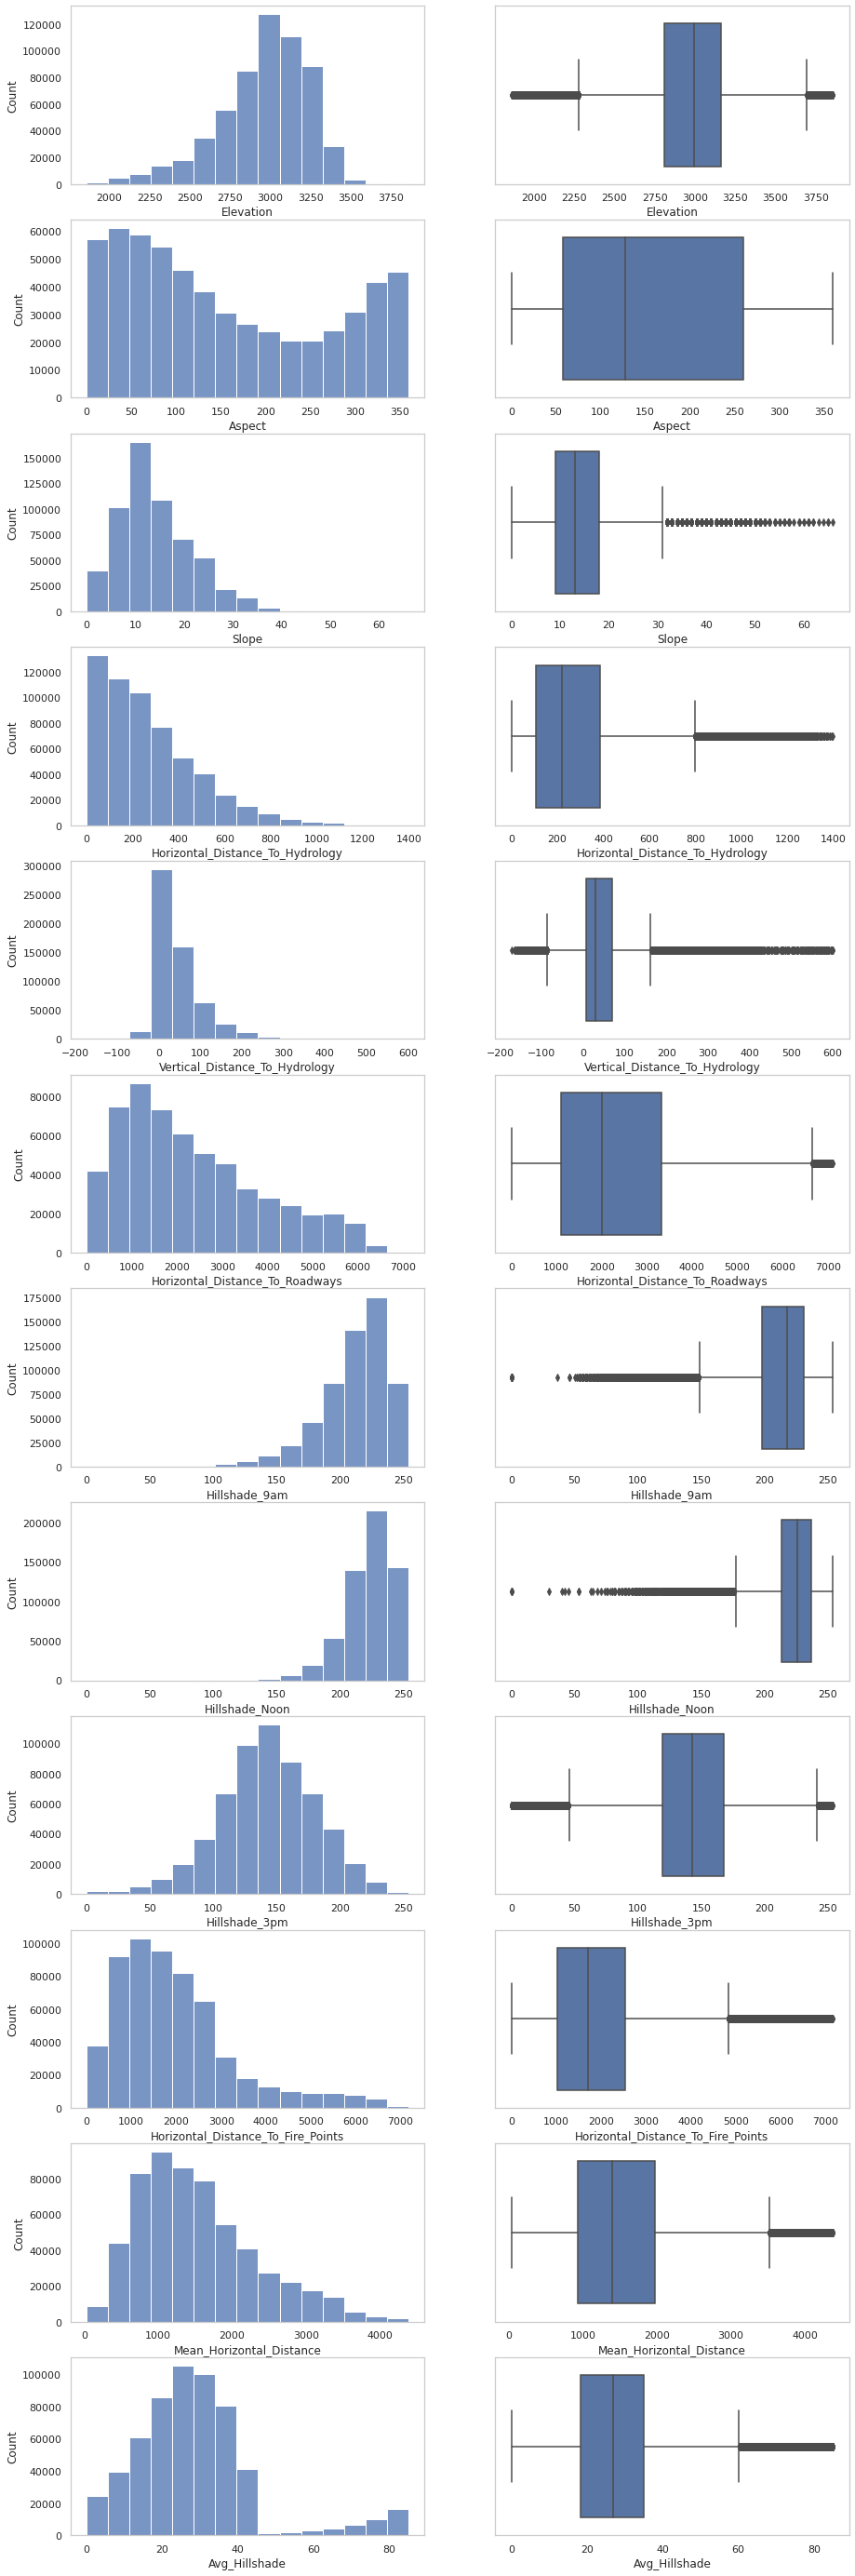

In [448]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axes = plt.subplots(numeric_features.columns.size, 2, figsize=(15, 50))

for i, feature in enumerate(numeric_features):
    sns.histplot(x = forest_data[feature], bins = 15, ax = axes[i, 0])
    sns.boxplot(x = forest_data[feature], ax = axes[i, 1])

Si nota che solo l'`Aspect` non ha valori fuori norma. Per quanto riguarda le altre variabili si osserva una notevole presenza di outlier per `Hillshade_9am`, `Hillshade_Noon` e `Vertical_Distance_To_Hydrology`.

### Analisi della distribuzione dei tipi di copertura forestale

Si vuole ora osservare la distribuzione delle classi da determinare.

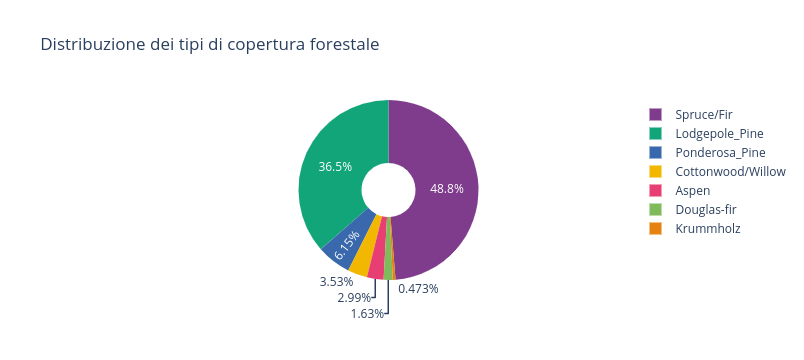

In [449]:
fig = go.Figure(
    data = [go.Pie(labels = list(cover_types.values()),
            values = forest_data["Cover_Type"].value_counts(),
            marker = dict(colors = px.colors.qualitative.Bold),
            hole = .3)]
)

fig.update_layout(title = "Distribuzione dei tipi di copertura forestale")
fig.show()

Si ha un forte sbilanciamento. Perciò è necessario applicare tecniche di sovracampionamento, come *smooting*, e sottocampionamento per equilibrare il numero di istanze appartenenti a ciascuna classe, in modo da migliorare la qualità dei risultati ottenibili.

### Analisi della distribuzione delle aree forestali

Si vuole ora osservare la distribuzione della variabile categorica `Wilderness_Area`.

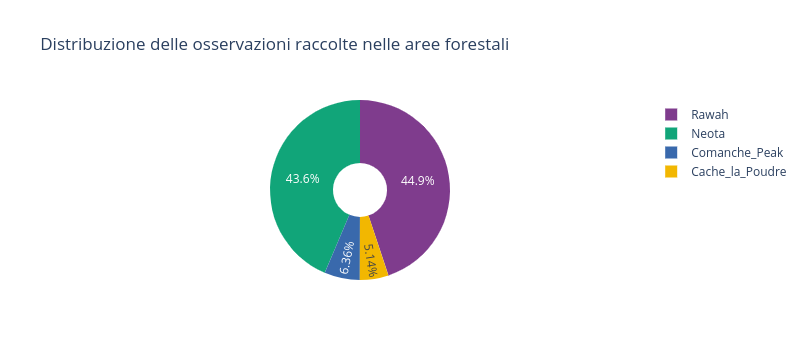

In [450]:
fig = go.Figure(
    data = [go.Pie(labels = list(wild_areas_types.values()),
            values = forest_data["Wilderness_Area"].value_counts(),
            marker = dict(colors = px.colors.qualitative.Bold),
            hole = .3)]
)

fig.update_layout(title = 
                  "Distribuzione delle osservazioni raccolte nelle aree forestali")
fig.show()

Si deduce che la maggior parte delle osservazioni provengono da Rawah e Neota.

### Analisi della distribuzione dei campioni di terreno

Distribuzione dei campioni di terreno raccolti complessivamente.

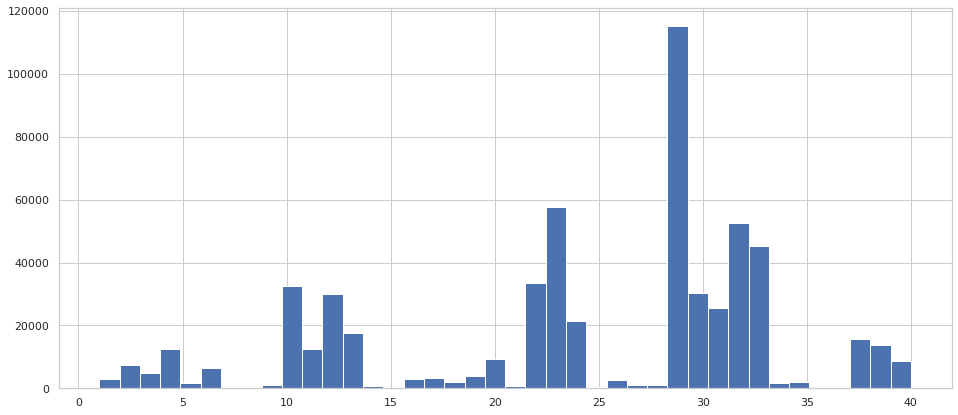

In [451]:
forest_data["Soil_Type"].hist(bins=40, figsize=(16,7));

Più nel dettaglio.

In [452]:
forest_data["Soil_Type"].value_counts()

29    115247
23     57752
32     52519
33     45154
22     33373
10     32634
30     30170
12     29971
31     25666
24     21278
13     17431
38     15573
39     13806
11     12410
4      12396
20      9259
40      8750
2       7525
6       6575
3       4823
19      4021
17      3422
1       3031
16      2845
26      2589
18      1899
35      1891
34      1611
5       1597
9       1147
27      1086
28       946
21       838
14       599
25       474
37       298
8        179
36       119
7        105
15         3
Name: Soil_Type, dtype: int64

### Analisi delle correlazioni tra caratteristiche numeriche

Per visualizzare le correlazioni tra le caratteristiche numeriche si impiega il metodo di Pearson.

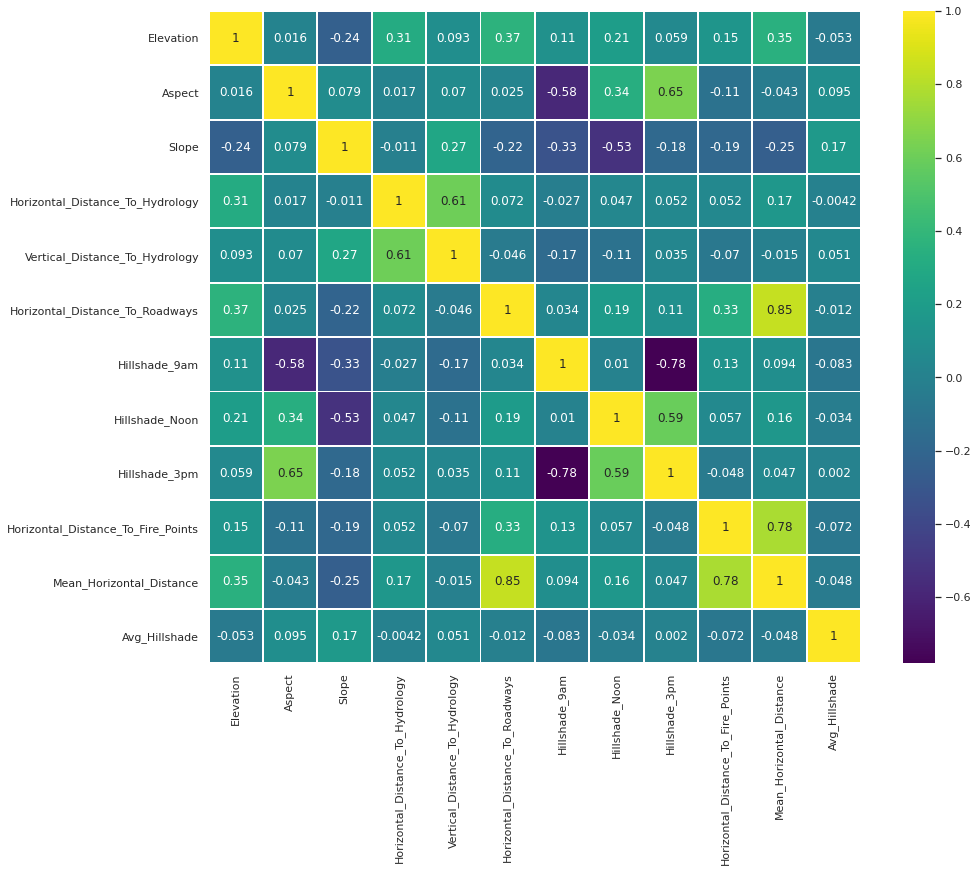

In [453]:
plt.figure(figsize = (15,12))
sns.heatmap(numeric_features.corr(method = 'pearson'),
            linewidths = 1,
            square = True,
            annot = True,
            cmap = "viridis");

Si osservano correlazioni positive significative:

- tra `Hillshade_3pm` e `Aspect`, `Vertical_Distance_To_Hydrology`;
- tra `Horizontal_Distance_To_Hydrology`;
- tra `Hillshade_3pm` e `Hillshade_Noon`.

Inoltre si osservano correlazioni negative significative:

- tra `Hillshade_3pm` e `Hillshade_9am`;
- tra `Hillshade_Noon` e `Slope`;
- tra `Hillshade_9am` e `Aspect`.

Per quanto riguarda le nuove caratteristiche `Avg_Hillshade` non ha introdotto alcuna correlazione mentre `Mean_Horizontal_Distance` ha introdotto due correlazioni significative con due delle tre variabili a partire dalle quali è stata creata, ovvero `Horizontal_Distance_To_Roadways` e `Horizontal_Distance_To_Fire_Points`.

A partire da alcune delle correlazioni individuate si tracciano dei grafici per poterle visualizzare.

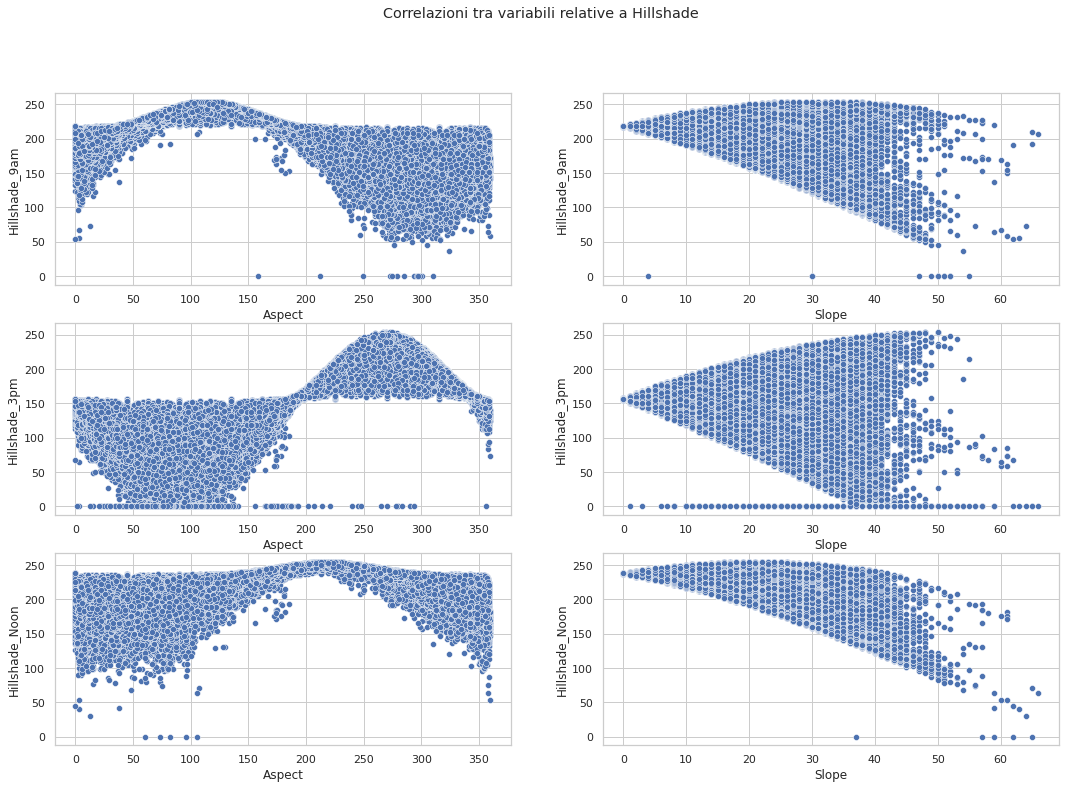

In [454]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Correlazioni tra variabili relative a Hillshade')

for i, feature in enumerate(['Hillshade_9am', 'Hillshade_3pm', 'Hillshade_Noon']):
    sns.scatterplot(ax = axes[i, 0],
                data = forest_data,
                x = 'Aspect',
                y = feature);
    
    sns.scatterplot(ax = axes[i, 1],
                data = forest_data,
                x = 'Slope',
                y = feature);

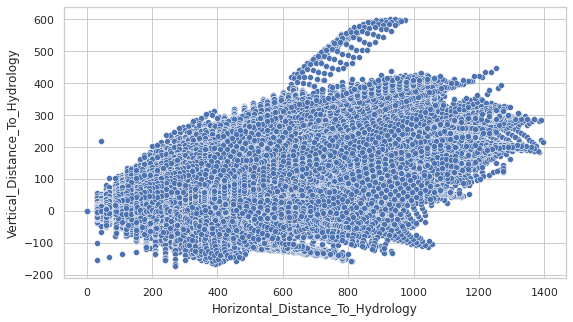

In [455]:
plt.figure(figsize=(9,5))
sns.scatterplot(data = forest_data,
                x = 'Horizontal_Distance_To_Hydrology',
                y = 'Vertical_Distance_To_Hydrology');

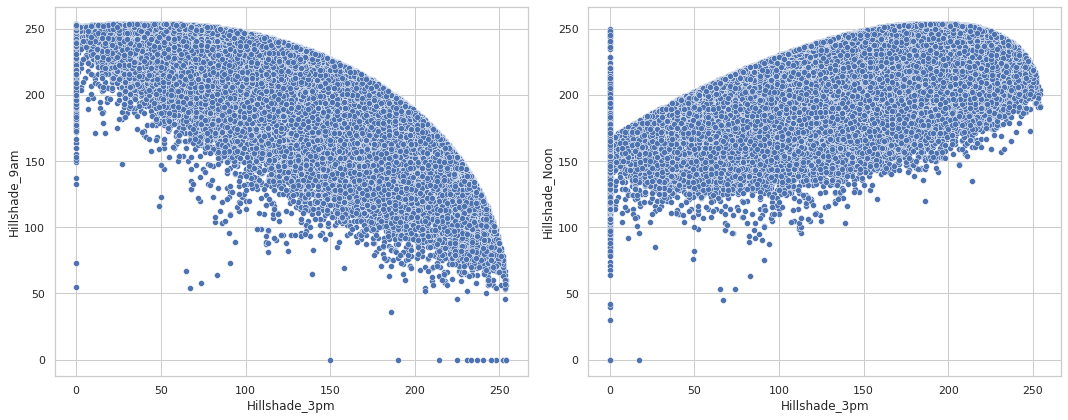

In [456]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(ax = axes[0],
                data = forest_data,
                x = 'Hillshade_3pm',
                y = 'Hillshade_9am');

sns.scatterplot(ax = axes[1],
                data = forest_data,
                x = 'Hillshade_3pm',
                y = 'Hillshade_Noon');

plt.tight_layout()
plt.show()

### Analisi delle correlazioni tra caratteristiche categoriche

Si vuole determinare se esistono correlazioni tra le caratteristiche categoriche osservando come si distribuiscono le tipologie di terreno in funzione del tipo di copertura forestale e in ciascun area.

In [457]:
y

0         0
1         0
2         4
3         4
4         0
         ..
581007    5
581008    5
581009    5
581010    5
581011    5
Name: Cover_Type, Length: 581012, dtype: int64

In [458]:
def get_wa_data(wa, X, y):
    X_wa = X[X['Wilderness_Area'] == wa]
    y_wa = y.loc[X_wa.index]
    return X_wa, y_wa

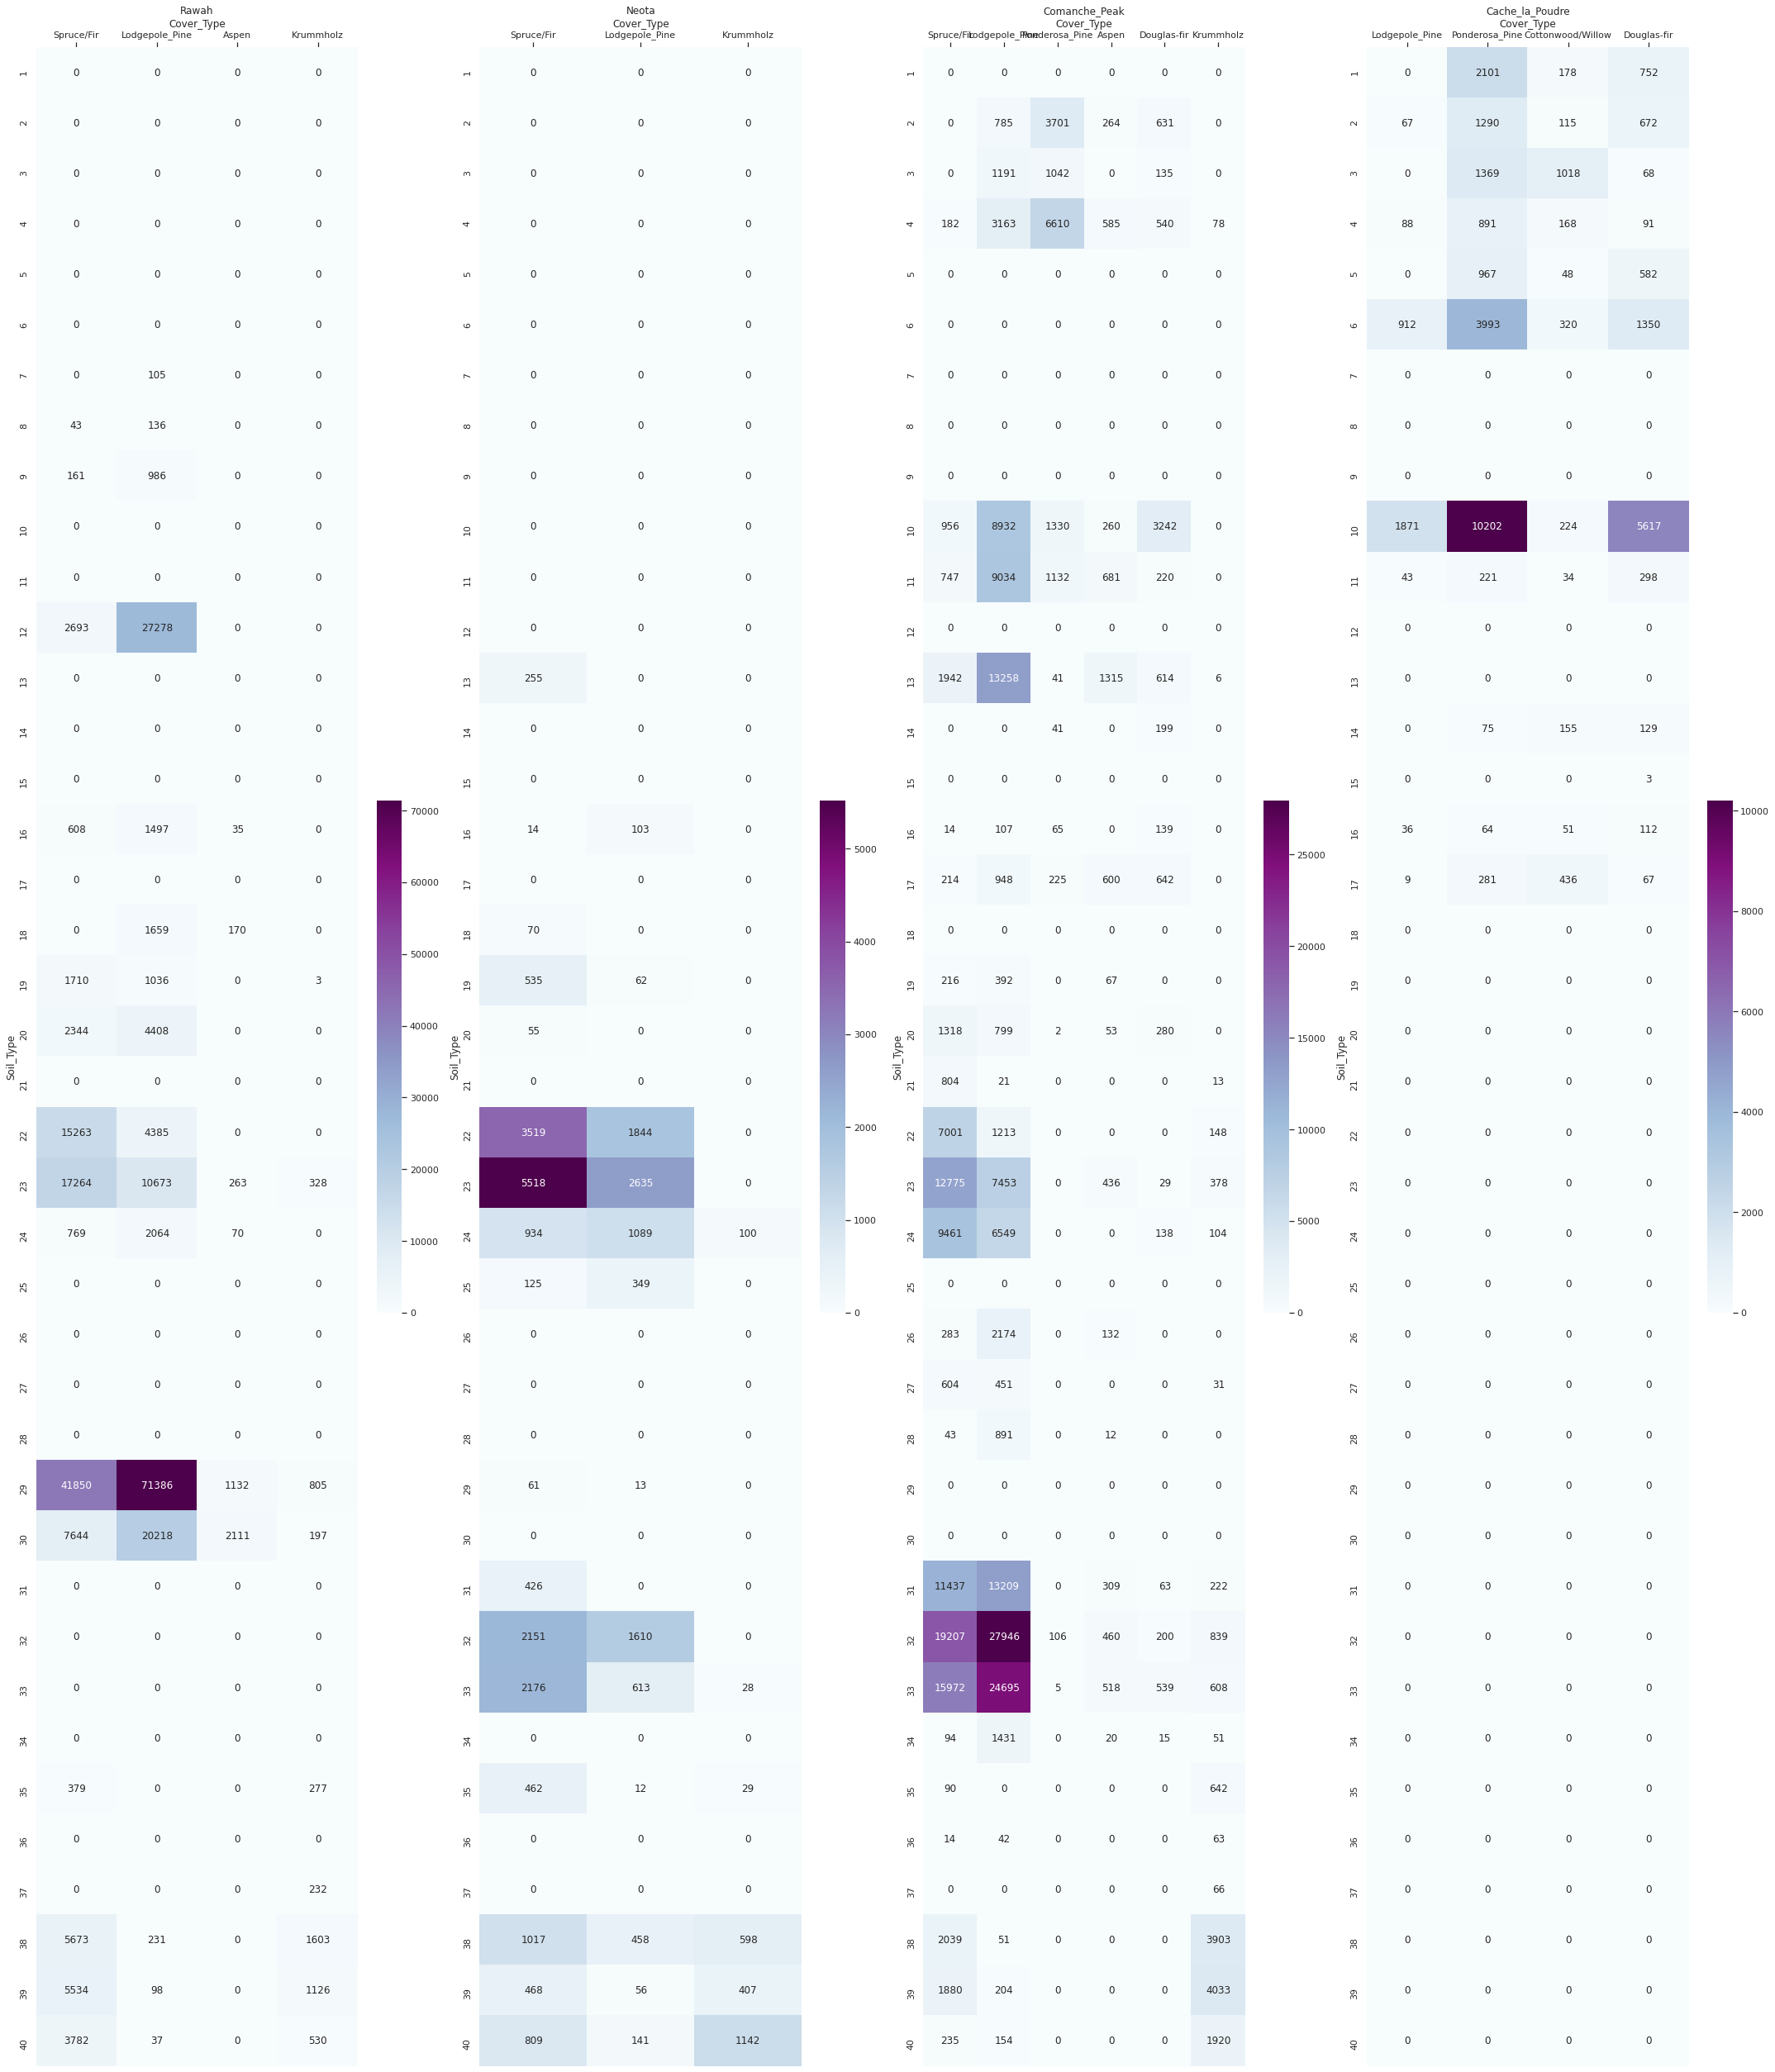

In [459]:
# thanks to https://www.kaggle.com/kwabenantim/forest-cover-feature-engineering
fig = plt.figure(figsize = (30, 35))

for wa in range(1, 5):
    X_wa, y_wa = get_wa_data(wild_areas_types.get(wa), forest_data, forest_data["Cover_Type"])
    soil_covers = pd.crosstab(X_wa["Soil_Type"], y_wa)
    missing_soils = set(range(1, 41)) - set(soil_covers.index)

    for soil in missing_soils:
        soil_covers.loc[soil] = 0
    
    soil_covers = soil_covers.sort_index()
    
    fig.add_subplot(1, 4, wa)
    ax = sns.heatmap(soil_covers,
                     annot = True,
                     cmap = "BuPu",
                     fmt = "d",
                     xticklabels = soil_covers.columns,
                     yticklabels = soil_covers.index, 
                     cbar_kws = {"fraction" : 0.07})
    
    ax.set(xlabel = "Cover_Type",
           ylabel = 'Soil_Type',
           title = wild_areas_types.get(wa))
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.show()

Tramite questo grafico è possibile osservare quali tipi di terreno sono più rari, in quale aree si concentrano e se il tipo di terreno può essere correlato al tipo di copertura forestale. Queste osservazioni saranno particolarmente utili quando si valuterà l'interpretabilità dei modelli.

### Analisi delle correlazioni tra caratteristiche categoriche e numeriche

Si vuole determinare se esistono correlazioni tra le caratteristiche numeriche e le categoriche osservando come si distribuiscono i valori assunti dalle caratteristiche numeriche in funzione dei valori considerati per ciascuna variabile categorica.

In seguito si visualizza la distribuzione di ciascuna delle caratteristiche numeriche riportate nel dataset rispetto a ciascun tipo di campione di terreno raccolto.

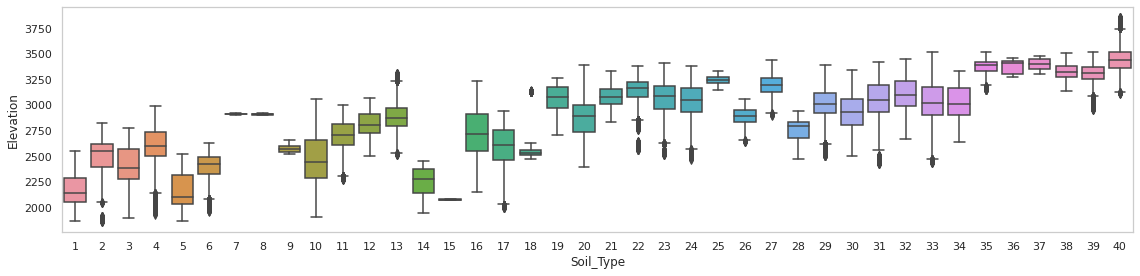

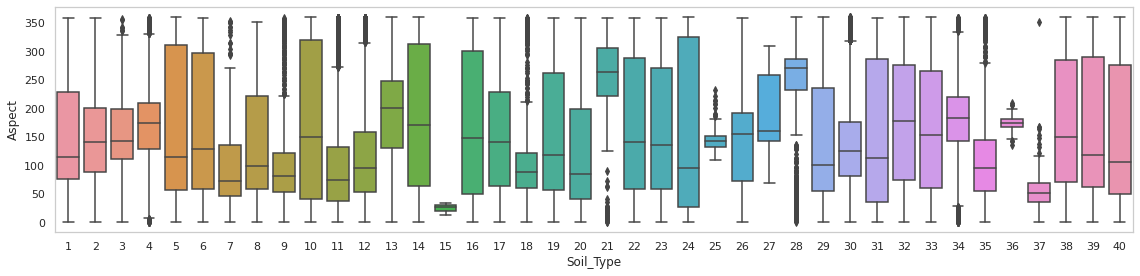

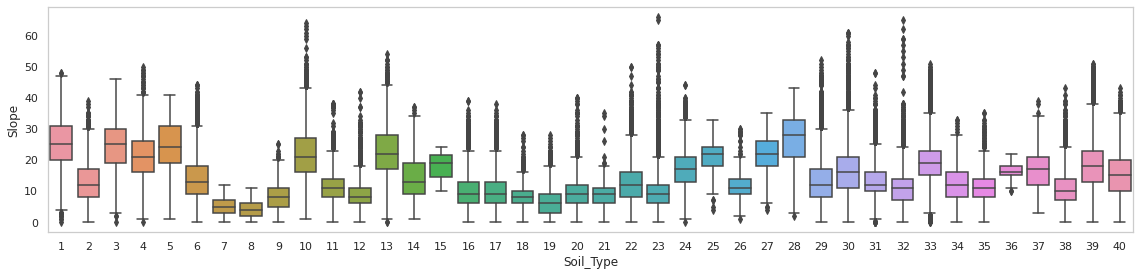

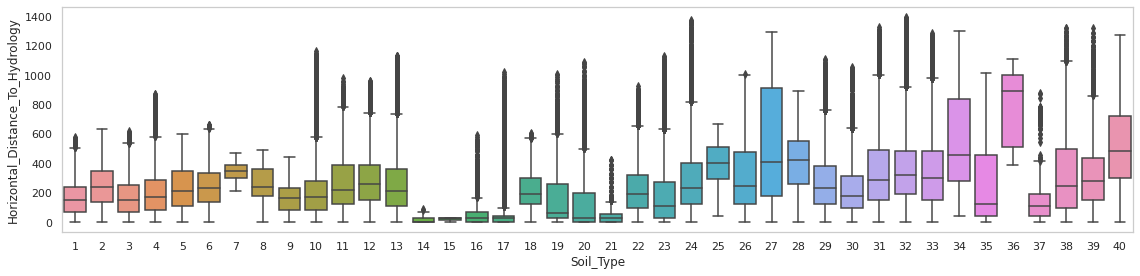

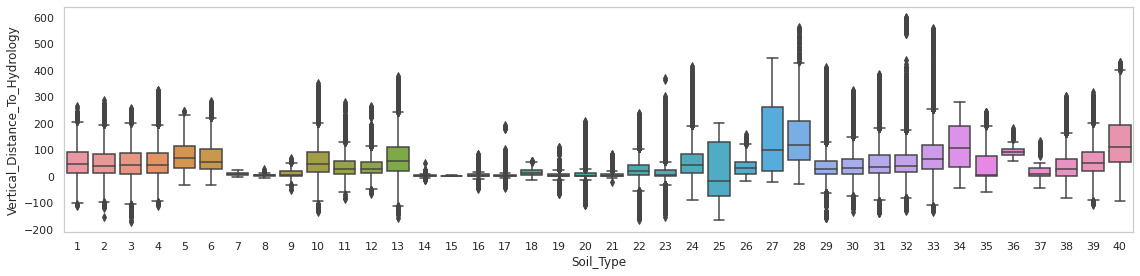

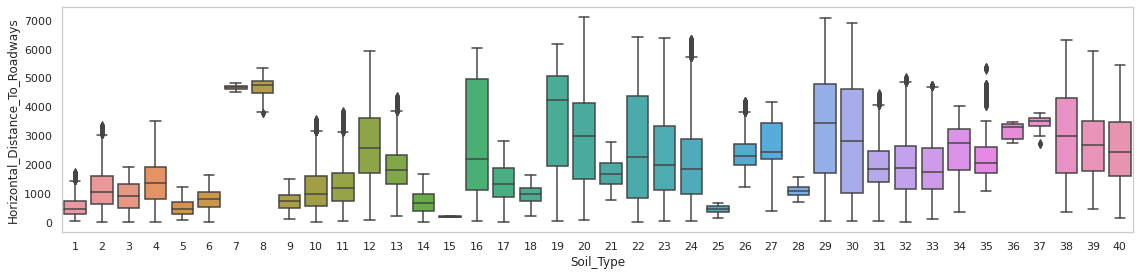

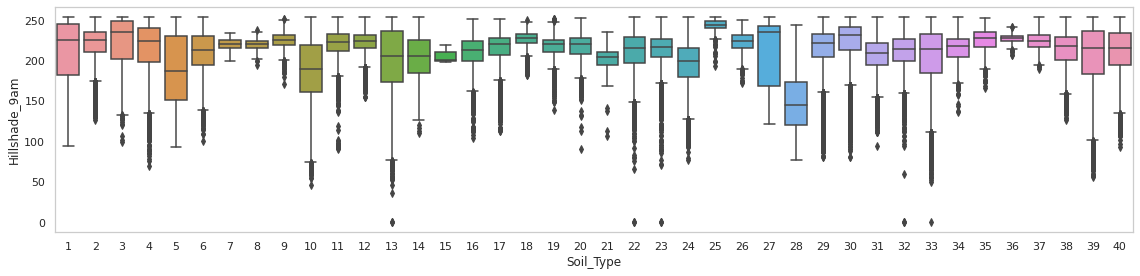

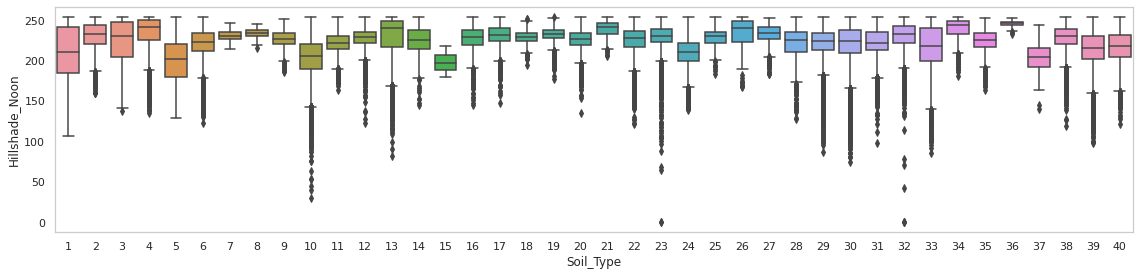

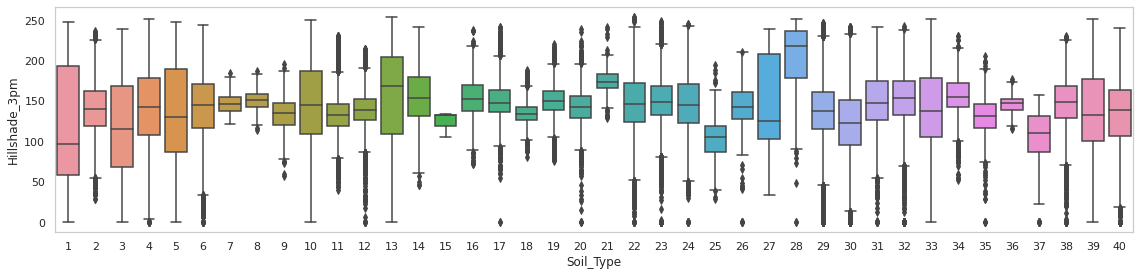

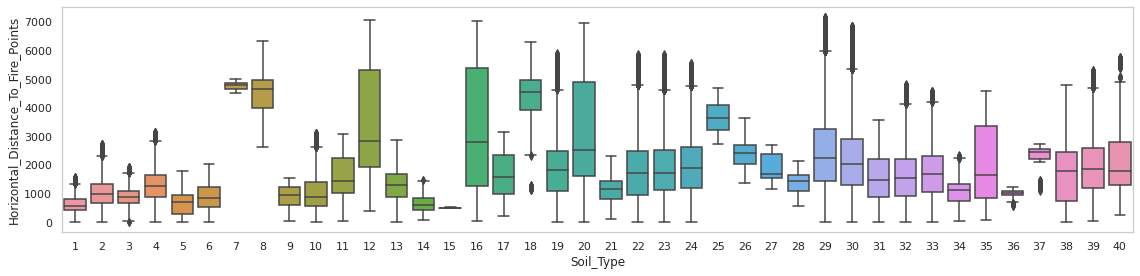

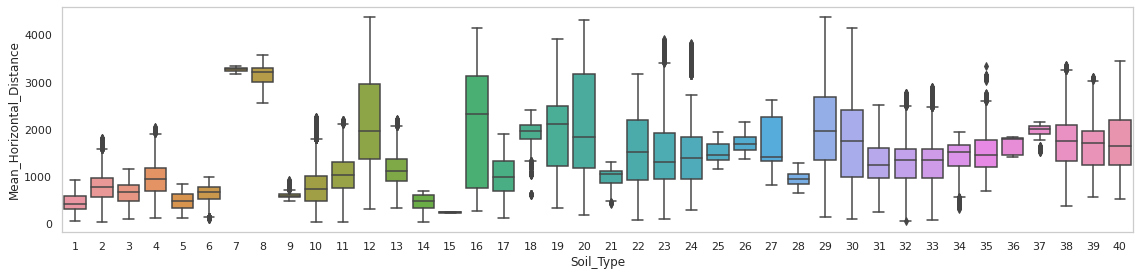

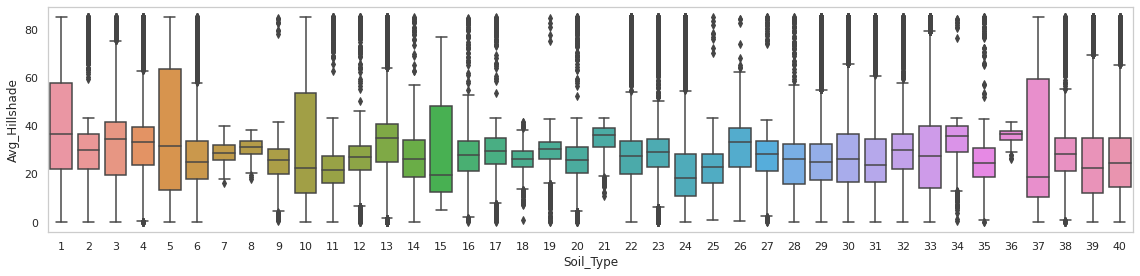

In [326]:
sns.set_style("whitegrid", {'axes.grid' : False})
for feature in numeric_features:
    fig = plt.figure(figsize = (16, 4))
    sns.boxplot(x = "Soil_Type",
                y = feature,
                data = forest_data)
    plt.tight_layout()
    plt.show()

In seguito si visualizza la distribuzione di ciascuna delle caratteristiche numeriche riportate nel dataset rispetto a ognuna delle quattro aree forestali considerate.

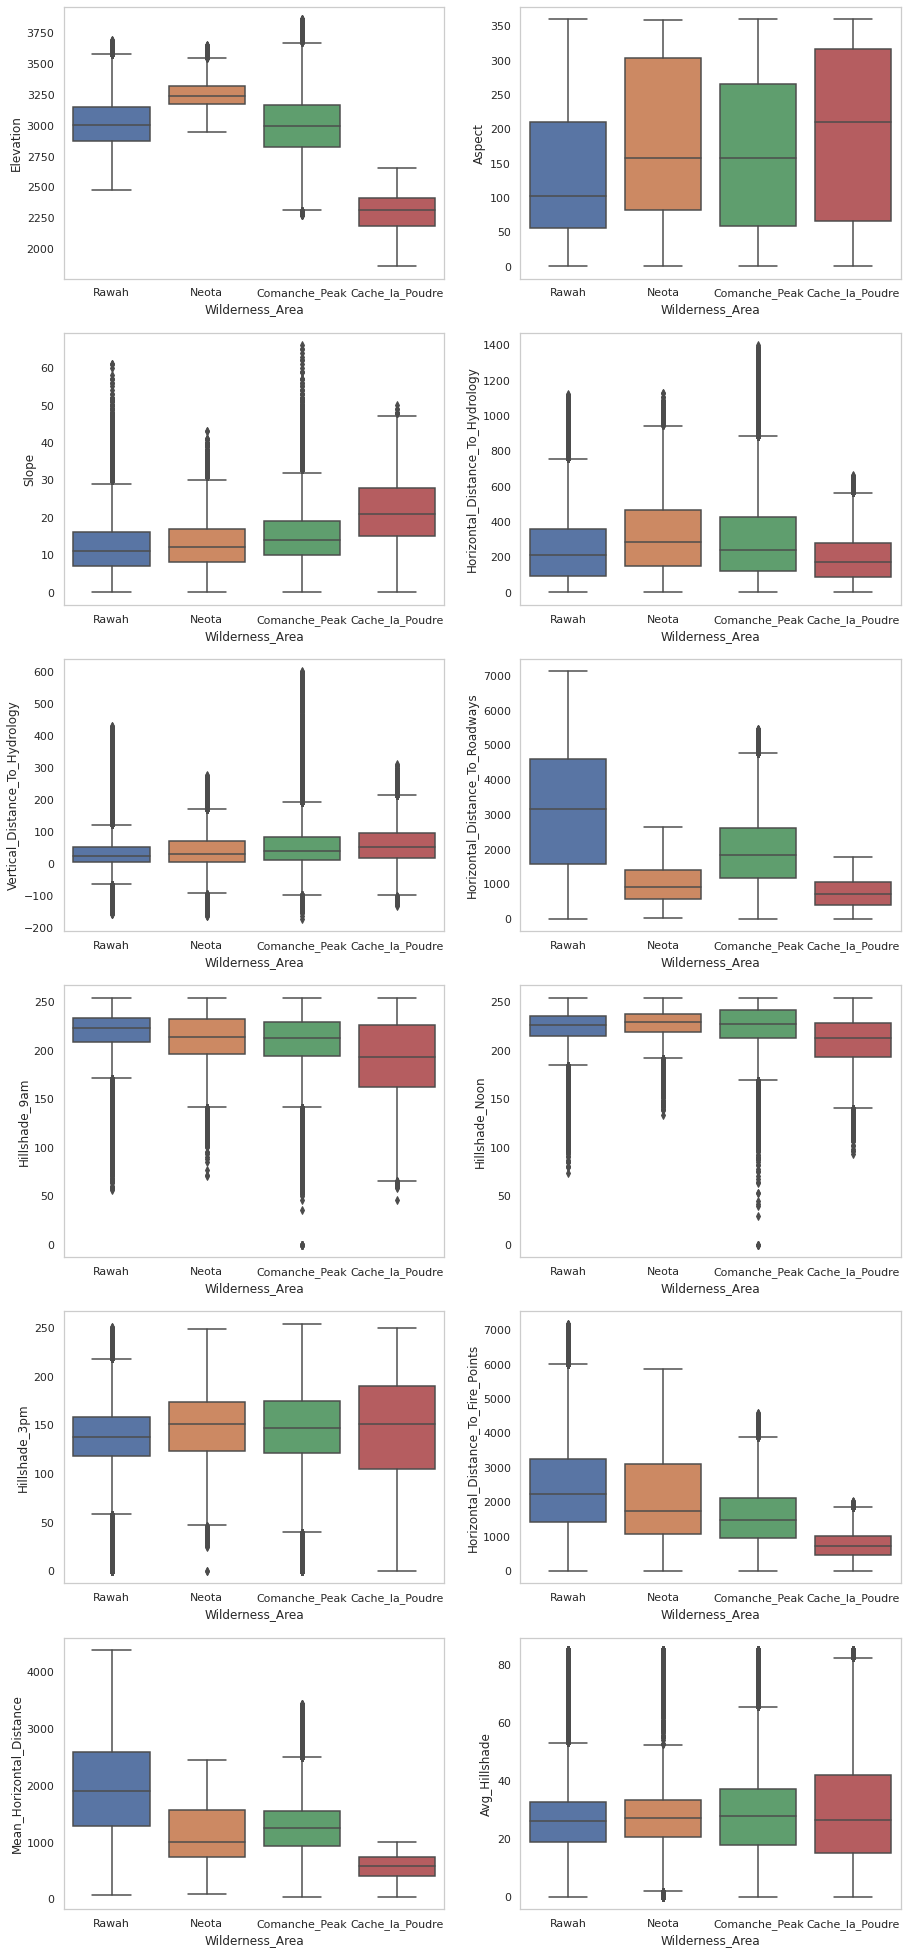

In [327]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize = (15, 35))
for i, feature in enumerate(numeric_features, start = 1):
    ax = sns.boxplot(x = 'Wilderness_Area',
                     y = feature,
                     data = forest_data,
                     ax = plt.subplot(int(numeric_features.columns.size / 2), 2, i))

In seguito si visualizza la distribuzione di ciascuna delle caratteristiche numeriche riportate nel dataset rispetto al tipo di coperatura forestale.

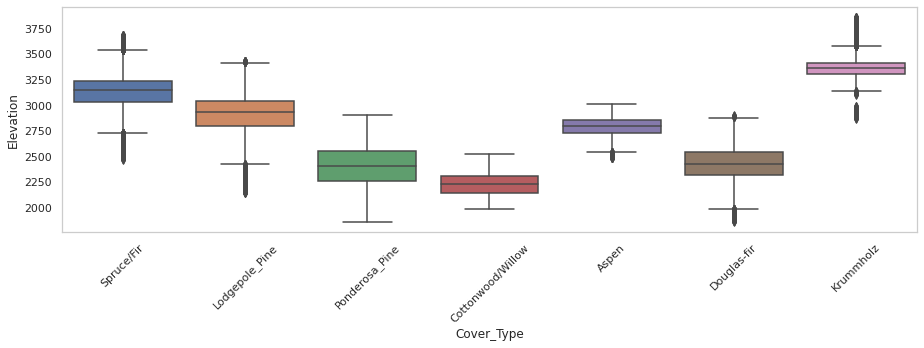

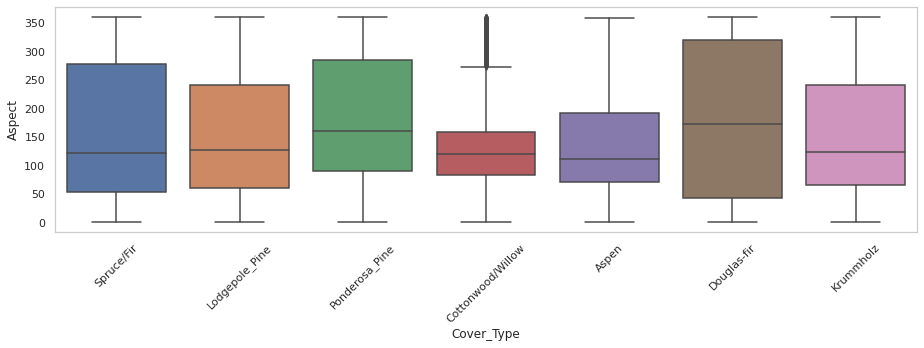

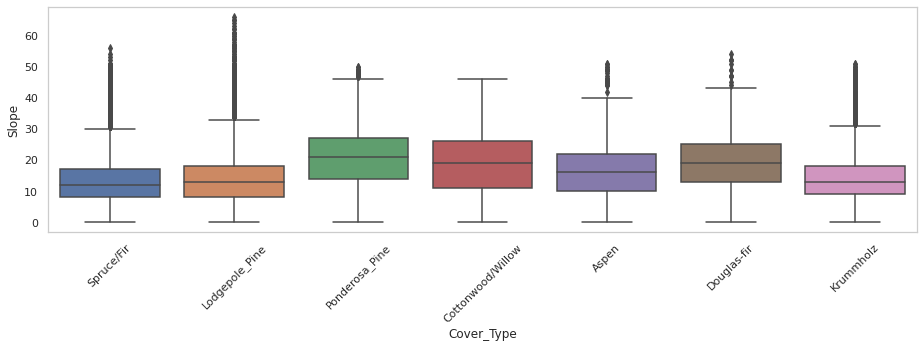

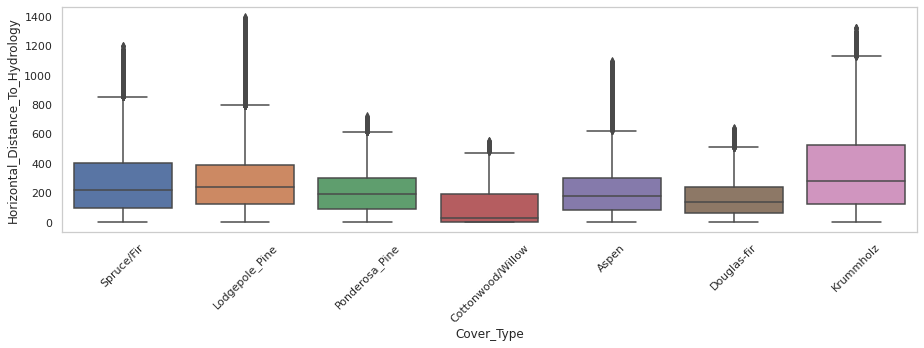

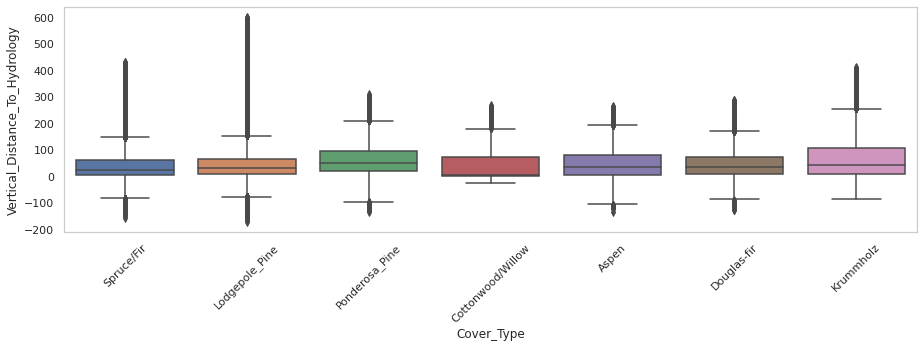

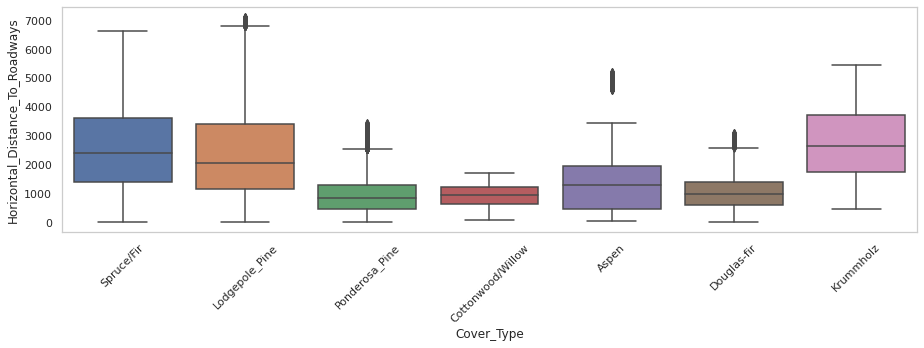

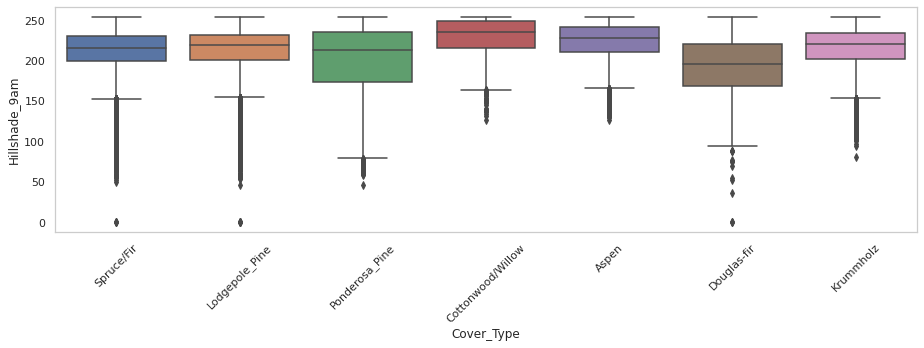

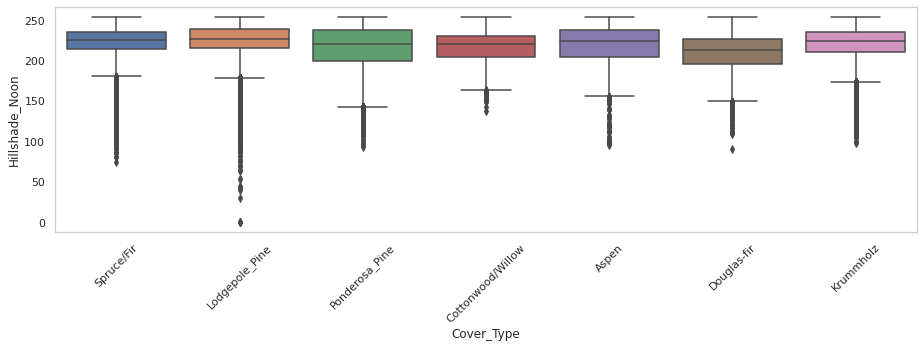

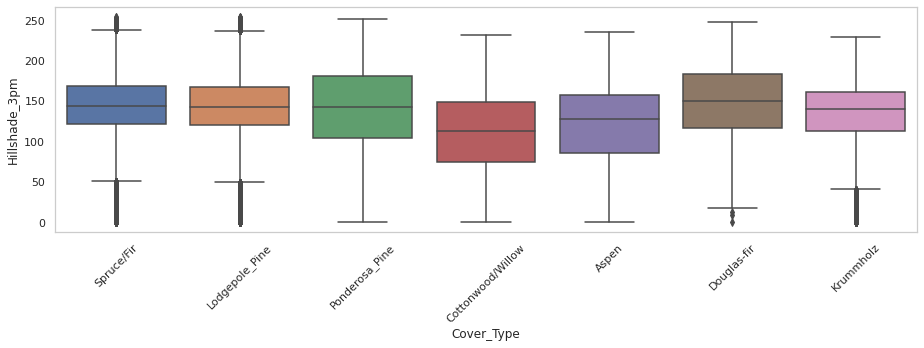

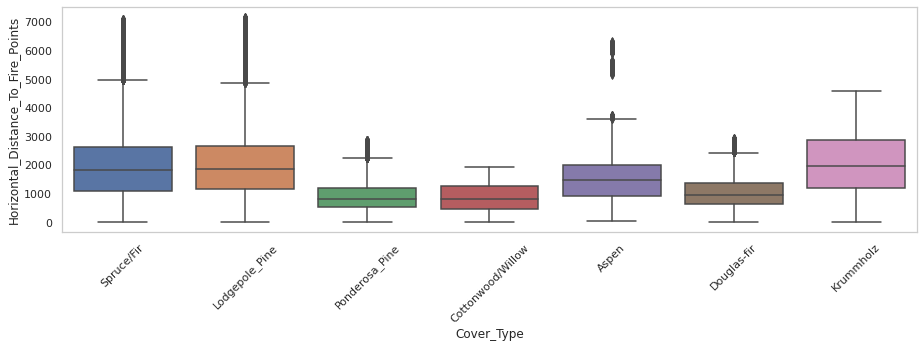

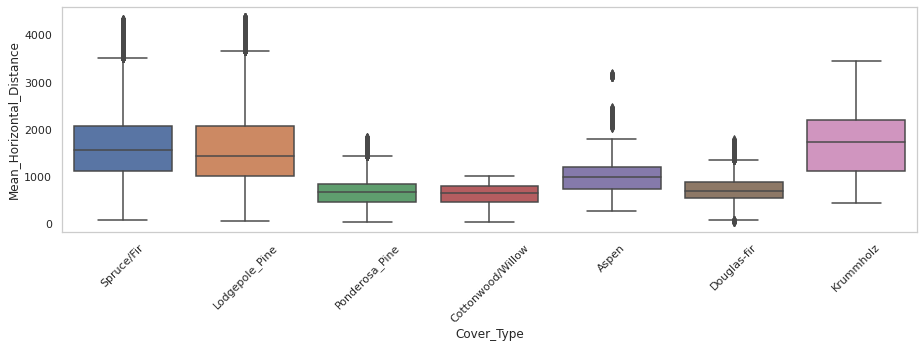

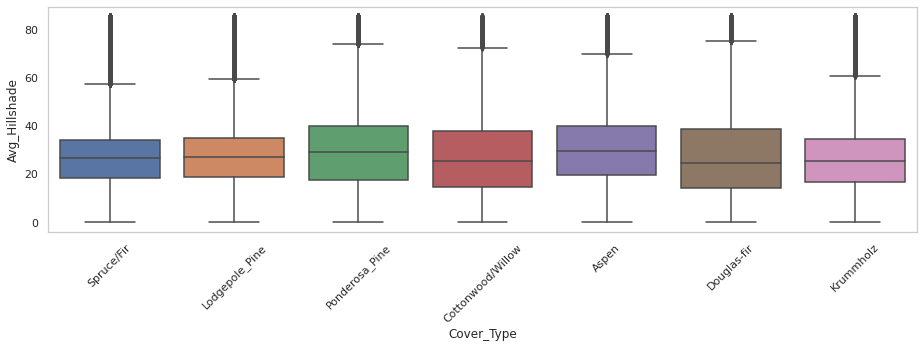

In [328]:
sns.set_style("whitegrid", {'axes.grid' : False})
for feature in numeric_features:
    fig = plt.figure(figsize=(13, 5))
    sns.boxplot(x = forest_data["Cover_Type"],
                y = feature,
                data = forest_data)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Rimozione di caratteristiche irrilevanti

Si potrebbero eliminare le caratteristiche con elevata correlazione come `Horizontal_Distance_To_Roadways` e `Horizontal_Distance_To_Fire_Points`, dato che `Mean_Horizontal_Distance` sembra avere maggiore importanza. Questo approccio è stato testato ma ha peggiorato le prestazioni dei modelli sia in termini di accuratezza che f1-score. Perciò non si elimineranno queste caratteristiche.

In ogni caso si applica la codifica _one_hot_ in preparazione dell'addestramento dei modelli e si rimuovono le colonne usate per semplificare l'analisi esplorativa. Inoltre si applica il `LabelEncoder` alla colonna `Cover_Type`.

In [329]:
forest_data = pd.concat([forest_data, 
                         pd.get_dummies(forest_data["Wilderness_Area"],
                                        prefix = "is")],
                        axis = 1)

forest_data = pd.concat([forest_data,
                         pd.get_dummies(forest_data["Soil_Type"],
                                        prefix = "is_soil_type")],
                        axis = 1)

forest_data = forest_data.drop(columns=["Wilderness_Area", "Soil_Type"])

In [330]:
label_encoder = LabelEncoder()
forest_data["Cover_Type"] = label_encoder.fit_transform(forest_data["Cover_Type"]);

## Bilanciamento delle classi

In [331]:
X = forest_data.drop(columns="Cover_Type")
y = forest_data["Cover_Type"]

In [332]:
y.value_counts()

4    283301
6    211840
5     35754
3     20510
2     17367
0      9493
1      2747
Name: Cover_Type, dtype: int64

In [333]:
sample_strategy = dict(y.value_counts())
sample_strategy[2] = 20000 # Douglas-fir
sample_strategy[0] = 20000 # Aspen
sample_strategy[1] = 20000 # Cottonwood/Willow

smote = SMOTE(sampling_strategy = sample_strategy,
              random_state = seed)

In [334]:
%%time
X_sm, y_sm = smote.fit_resample(X, y)

rus = RandomUnderSampler(sampling_strategy='auto',
                         random_state=seed)
X_sm, y_sm = rus.fit_resample(X_sm, y_sm)

CPU times: user 17.3 s, sys: 50.6 s, total: 1min 7s
Wall time: 7.83 s


In [335]:
y_sm.value_counts()

6    20000
5    20000
4    20000
3    20000
2    20000
1    20000
0    20000
Name: Cover_Type, dtype: int64

## Suddivisione dei dati

Creazione di training set, test set e validation set. L'analisi esplorativa sarà condotta solo sui dati impiegati per l'addestramento in modo da velocizzare l'analisi.

In [336]:
X_dataset, X_test, y_dataset, y_test = train_test_split(X_sm,
                                                        y_sm,
                                                        test_size = 0.1,
                                                        random_state = 41)

In [337]:
X_train, X_val, y_train, y_val = train_test_split(X_dataset,
                                                  y_dataset,
                                                  test_size = 0.33,
                                                  random_state = 43)

In [338]:
X_train.shape

(84420, 56)

In [339]:
y_train.shape

(84420,)

In [340]:
X_val.shape

(41580, 56)

In [341]:
y_val.shape

(41580,)

In [342]:
X_test.shape

(14000, 56)

In [343]:
y_test.shape

(14000,)

## Addestramento e validazione dei modelli 

- In tutti i modelli la ricerca degli iperparametri migliori impiega unicamente la `GridSearchCV`. La nested cross validation non è stata impiegata per limitare i tempi di computazione. In molti casi si addestrano i modelli direttamente con i parametri migliori trovati.
- La standardizzazione del training set sarà effettuata successivamente nelle pipeline di ciascun modello.

### Perceptron

Si esegue una grid search sul training set con cross validation a 3 fold stratificati casuali per individuare il modello Perceptron con parametri migliori secondo le seguenti specifiche:

  - standardizzazione delle variabili
  - `alpha` variabile tra 0.0001, 0.001, 0.01, 1
  - `tol` variabile tra 1e-12, 1e-9, 1e-6, 1e-3

In [344]:
perceptron = Pipeline([
    ("scaler", StandardScaler()),
    ("perceptron", Perceptron(n_jobs = njobs,
                              random_state = seed,
                              alpha = 0.0001,
                              tol = 0.001))
])

grid = {
    "perceptron__alpha": [0.0001, 0.001, 0.01, 1],
    "perceptron__tol": [1e-12, 1e-9, 1e-6, 1e-3]
}

skf = StratifiedKFold(5, shuffle = True)
perceptron_gs = GridSearchCV(perceptron, grid, cv = skf)

In [345]:
%%time
perceptron_gs.fit(X_train, y_train);

CPU times: user 1min 42s, sys: 1min 27s, total: 3min 9s
Wall time: 30.6 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('perceptron',
                                        Perceptron(n_jobs=-1,
                                                   random_state=43))]),
             param_grid={'perceptron__alpha': [0.0001, 0.001, 0.01, 1],
                         'perceptron__tol': [1e-12, 1e-09, 1e-06, 0.001]})

In [346]:
perceptron_gs.best_params_

{'perceptron__alpha': 0.0001, 'perceptron__tol': 1e-12}

Si stabilisce un intervallo di confidenza del modello con i  migliori parametri determinati e si visualizza la matrice di confusione e i punteggi relativi alle metriche f1-score, recall, precision e support per capire come si comporta il modello e per poterlo confrontare con i successivi.

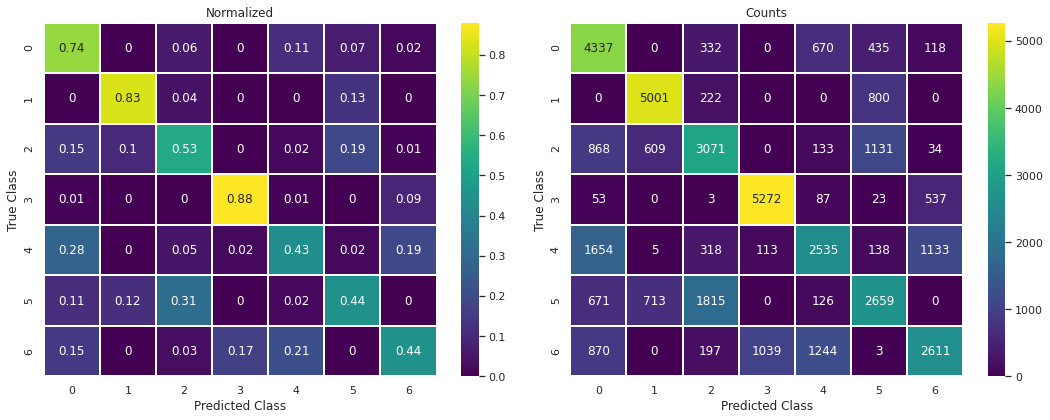

In [347]:
plot_confusion_matrix(perceptron_gs.predict(X_val),
                      perceptron_gs.classes_, y_val)

In [348]:
report_perc = print_model_stats(perceptron_gs, X_val, y_val);

+----+-------------+----------+------------+-----------+
|    |   precision |   recall |   f1-score |   support |
|----+-------------+----------+------------+-----------|
|  0 |    0.513072 | 0.736083 |   0.604671 |      5892 |
|  1 |    0.790297 | 0.830317 |   0.809813 |      6023 |
|  2 |    0.515441 | 0.525316 |   0.520332 |      5846 |
|  3 |    0.820672 | 0.882343 |   0.850391 |      5975 |
|  4 |    0.528676 | 0.429953 |   0.474231 |      5896 |
|  5 |    0.51243  | 0.444352 |   0.475969 |      5984 |
|  6 |    0.588992 | 0.437793 |   0.50226  |      5964 |
+----+-------------+----------+------------+-----------+
f1-score (macro avg) at 95% confidence:	 [0.60067, 0.61007]
Accuracy at 95% confidence:		 [0.60825, 0.61761]


### Regressione Logistica

Si esegue una grid search sul training set con cross validation a 3 fold stratificati casuali per individuare il modello di regressione logistica con parametri migliori secondo le seguenti specifiche:

  - standardizzazione delle variabili
  - regolarizzazione `l2` oppure `l1`
  - costo `C` variabile tra 0.01, 0.1, 1, 10
  - modalità `multi_class` pari a `ovr` o `multinomial`
  - `solver` di uno dei tipi disponibili, `lbfgs`, `newton-cg`, `liblinear`, `saga` o `sag` 

In [349]:
logistic_regression = Pipeline([
    ("scaler", StandardScaler()), 
    ("logistic", LogisticRegression(random_state = seed,
                                    n_jobs = njobs,
                                    multi_class = "multinomial",
                                    solver = "newton-cg",
#                                     C = 10,
                                    penalty = "l2"
                                   ))
])

# parameters = {
#     "logistic__multi_class" : ["multinomial", "ovr"],
#     "logistic__solver" : ["lbfgs", "newton-cg", "liblinear", "saga", "sag"]   
#     "logistic__C" : [0.01, 0.1, 1, 10],
#     "logistic__penalty" : ["l1", "l2"]
# }

# skf = StratifiedKFold(3, shuffle = True)
# logistic_regression_gs = GridSearchCV(logistic_regression,
#                                       parameters,
#                                       cv = skf,
#                                       n_jobs = njobs)

In [350]:
%%time
logistic_regression.fit(X_train, y_train)

CPU times: user 172 ms, sys: 915 ms, total: 1.09 s
Wall time: 36.6 s


Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(multi_class='multinomial', n_jobs=-1,
                                    random_state=43, solver='newton-cg'))])

In [351]:
# logistic_regression_gs.best_params_

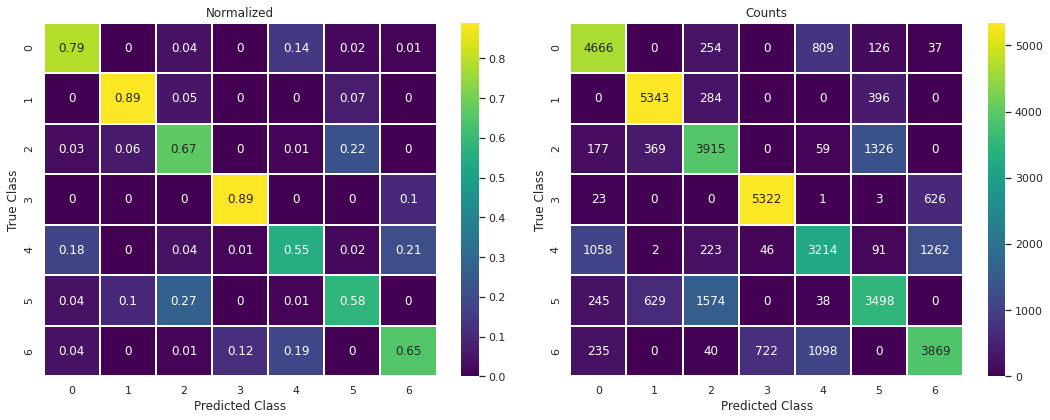

In [352]:
plot_confusion_matrix(logistic_regression.predict(X_val),
                      logistic_regression.classes_,
                      y_val)

In [353]:
report_logreg = print_model_stats(logistic_regression, X_val, y_val);

+----+-------------+----------+------------+-----------+
|    |   precision |   recall |   f1-score |   support |
|----+-------------+----------+------------+-----------|
|  0 |    0.728607 | 0.791921 |   0.758946 |      5892 |
|  1 |    0.842346 | 0.887099 |   0.864144 |      6023 |
|  2 |    0.622417 | 0.669689 |   0.645188 |      5846 |
|  3 |    0.873892 | 0.890711 |   0.882221 |      5975 |
|  4 |    0.615827 | 0.545115 |   0.578318 |      5896 |
|  5 |    0.643015 | 0.584559 |   0.612395 |      5984 |
|  6 |    0.66776  | 0.648726 |   0.658105 |      5964 |
+----+-------------+----------+------------+-----------+
f1-score (macro avg) at 95% confidence:	 [0.70983, 0.71851]
Accuracy at 95% confidence:		 [0.71299, 0.72165]


### SVM

Si esegue una grid search sul training set con cross validation a 3 fold stratificati casuali per individuare il modello SVM con parametri migliori secondo le seguenti specifiche:

  - standardizzazione delle variabili
  - fattore di regolarizzazione `C` variabile in 0.01, 0.1, 1, 10

In [354]:
svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state = seed,
                kernel = "rbf",
                C = 1))
])

# parameters = {
#     "svm__C" : [0.01, 0.1, 1, 10]
# }

# skf = StratifiedKFold(3, shuffle = True)
# svm_gs = GridSearchCV(svm,
#                       parameters,
#                       cv = skf,
#                       refit = True)

In [355]:
%%time
svm.fit(X_train, y_train)

CPU times: user 2min 27s, sys: 25.9 ms, total: 2min 27s
Wall time: 2min 27s


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=1, random_state=43))])

In [356]:
# svm_gs.best_params_

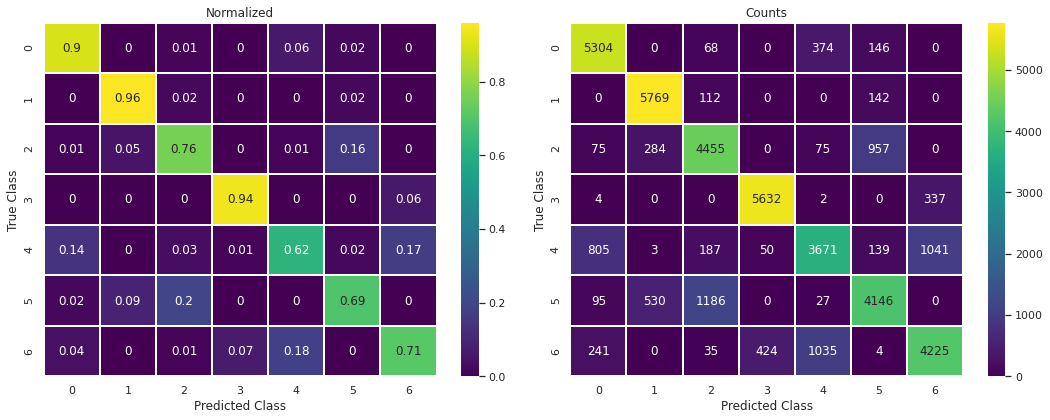

In [357]:
plot_confusion_matrix(svm.predict(X_val),
                      svm.classes_, 
                      y_val)

In [358]:
report_svm = print_model_stats(svm, X_val, y_val);

+----+-------------+----------+------------+-----------+
|    |   precision |   recall |   f1-score |   support |
|----+-------------+----------+------------+-----------|
|  0 |    0.812998 | 0.900204 |   0.854381 |      5892 |
|  1 |    0.875949 | 0.957828 |   0.915061 |      6023 |
|  2 |    0.737217 | 0.76206  |   0.749432 |      5846 |
|  3 |    0.922371 | 0.942594 |   0.932373 |      5975 |
|  4 |    0.70814  | 0.622626 |   0.662635 |      5896 |
|  5 |    0.749187 | 0.692848 |   0.719917 |      5984 |
|  6 |    0.75406  | 0.708417 |   0.730526 |      5964 |
+----+-------------+----------+------------+-----------+
f1-score (macro avg) at 95% confidence:	 [0.79100, 0.79876]
Accuracy at 95% confidence:		 [0.79463, 0.80234]


### Multi-layer perceptron

Si esegue una grid search sul training set con cross validation a 3 fold stratificati casuali per individuare il modello Multi-layer perceptron con parametri migliori secondo le seguenti specifiche:

  - standardizzazione delle variabili
  - 4 possibili configurazioni degli strati nascosti (`hidden_layer_sizes`)
    - uno strato di 49 variabili
    - due strati di 49 e 7 variabili rispettivamente
    - uno strato di 56 variabili
    - due strati di 56 e 7 variabili rispettivamente

In [359]:
multilayer_perceptron = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(activation = "relu", 
                          batch_size = 50,
                          max_iter = 300,
                          random_state = seed,
                          hidden_layer_sizes = (56, 7)))
])

# parameters = {
#     "mlp__hidden_layer_sizes": [49, (49, 7), 56, (56, 7)],
# }

# skf = StratifiedKFold(3, shuffle = True)

# gs = GridSearchCV(model,
#                   parameters,
#                   cv = skf)

In [360]:
%%time
multilayer_perceptron.fit(X_train, y_train);

CPU times: user 3min 16s, sys: 984 µs, total: 3min 16s
Wall time: 3min 16s


/home/richard/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(batch_size=50, hidden_layer_sizes=(56, 7),
                               max_iter=300, random_state=43))])

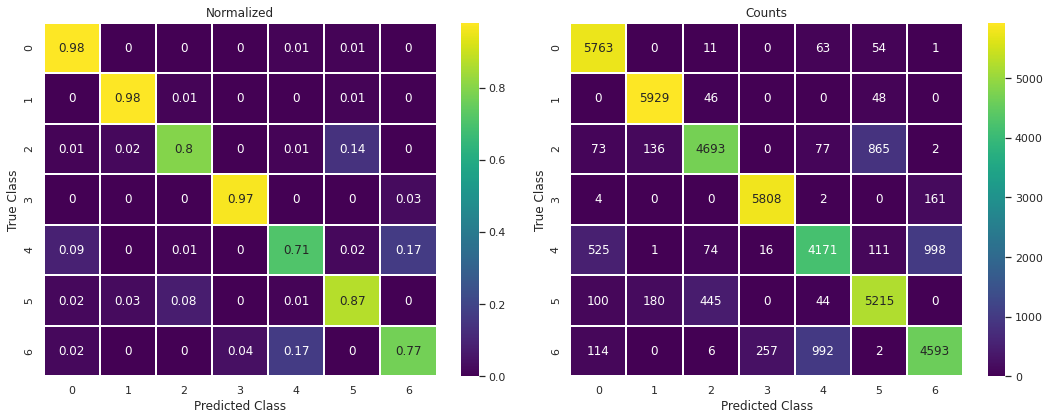

In [361]:
plot_confusion_matrix(multilayer_perceptron.predict(X_val),
                      multilayer_perceptron.classes_, 
                      y_val)

In [362]:
report_mlp = print_model_stats(multilayer_perceptron, X_val, y_val);

+----+-------------+----------+------------+-----------+
|    |   precision |   recall |   f1-score |   support |
|----+-------------+----------+------------+-----------|
|  0 |    0.875969 | 0.978106 |   0.924224 |      5892 |
|  1 |    0.949248 | 0.984393 |   0.966501 |      6023 |
|  2 |    0.889668 | 0.802771 |   0.843989 |      5846 |
|  3 |    0.955106 | 0.97205  |   0.963504 |      5975 |
|  4 |    0.779772 | 0.707429 |   0.741841 |      5896 |
|  5 |    0.828435 | 0.871491 |   0.849418 |      5984 |
|  6 |    0.798089 | 0.770121 |   0.783855 |      5964 |
+----+-------------+----------+------------+-----------+
f1-score (macro avg) at 95% confidence:	 [0.86433, 0.87084]
Accuracy at 95% confidence:		 [0.86667, 0.87314]


### Decision Tree

Si esegue una grid search sul training set con cross validation a 3 fold stratificati casuali per individuare il modello Decision Tree con parametri migliori secondo le seguenti specifiche:

  - standardizzazione delle variabili
  - numero massimo di caratteristiche (`max_features`) variabile in $[2,54]$

In [363]:
decision_tree = Pipeline([
      ("std", StandardScaler()),
      ("decisiontree", DecisionTreeClassifier(random_state = seed))
])

parameters = {
    "decisiontree__max_features" : range(2, 54, 1)
}

skf = StratifiedKFold(3, shuffle = True)
decision_tree_gs = GridSearchCV(decision_tree,
                                parameters,
                                cv = skf,
                                n_jobs = njobs)

In [364]:
%%time
decision_tree_gs.fit(X_train, y_train)

CPU times: user 2.67 s, sys: 942 ms, total: 3.62 s
Wall time: 12 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('decisiontree',
                                        DecisionTreeClassifier(random_state=43))]),
             n_jobs=-1,
             param_grid={'decisiontree__max_features': range(2, 54)})

In [365]:
decision_tree_gs.best_params_

{'decisiontree__max_features': 43}

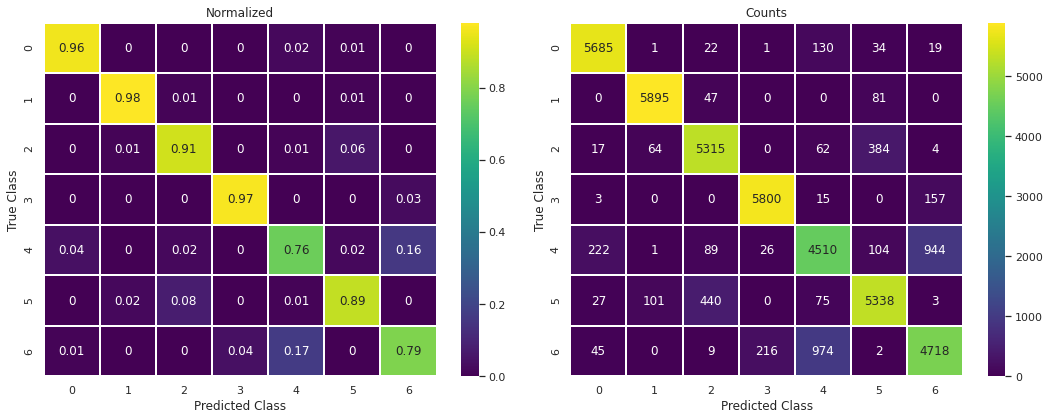

In [366]:
plot_confusion_matrix(decision_tree_gs.predict(X_val), decision_tree_gs.classes_, y_val)

In [367]:
report_dtr = print_model_stats(decision_tree_gs, X_val, y_val);

+----+-------------+----------+------------+-----------+
|    |   precision |   recall |   f1-score |   support |
|----+-------------+----------+------------+-----------|
|  0 |    0.947658 | 0.964868 |   0.956185 |      5892 |
|  1 |    0.972451 | 0.978748 |   0.97559  |      6023 |
|  2 |    0.897501 | 0.909169 |   0.903297 |      5846 |
|  3 |    0.959788 | 0.970711 |   0.965219 |      5975 |
|  4 |    0.782171 | 0.764925 |   0.773452 |      5896 |
|  5 |    0.8982   | 0.892045 |   0.895112 |      5984 |
|  6 |    0.807186 | 0.79108  |   0.799052 |      5964 |
+----+-------------+----------+------------+-----------+
f1-score (macro avg) at 95% confidence:	 [0.89244, 0.89832]
Accuracy at 95% confidence:		 [0.89316, 0.89902]


In [368]:
decision_tree_model = decision_tree_gs.best_estimator_.named_steps["decisiontree"]
decision_tree_depth = decision_tree_model.get_depth()
decision_tree_leaves = decision_tree_model.get_n_leaves()
print(f"Depth: {decision_tree_depth}, Leaves: {decision_tree_leaves}")

Depth: 37, Leaves: 6856


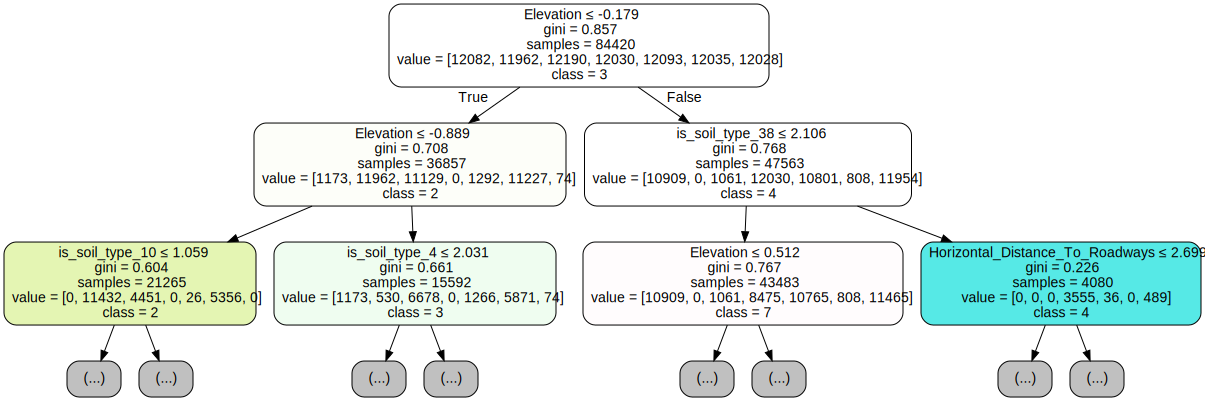

In [369]:
data = export_graphviz(decision_tree_model,
                       out_file = None,
                       feature_names = X_train.columns,
                       class_names = ["1", "2", "3", "4", "5", "6", "7"],  
                       filled = True, 
                       rounded = True,  
                       max_depth = 2,
                       special_characters = True)

graph = graphviz.Source(data)
graph

### Random Forest

Si esegue una grid search sul training set con cross validation a 3 fold stratificati casuali per individuare il modello Random Forest con parametri migliori secondo le seguenti specifiche:

  - standardizzazione delle variabili
  - numero di alberi nella foresta (`n_estimators`) variabile in 100, 200, 300
  - numero massimo di caratteristiche (`max_features`) variabile in $[2,54]$ o calcolato impiegando la radice quadrata o il logaritmo

In [370]:
random_forest = Pipeline([
    ("std", StandardScaler()),
    ("rfc", RandomForestClassifier(random_state = seed,
                                   n_jobs = njobs,
                                   max_features = "sqrt",
                                   n_estimators = 300))
])

# parameters = {
#     "rfc__n_estimators": [100, 200, 300],
#     "rfc__max_features": ["sqrt", "log2", range(2, 54, 1)]
# }

# skf = StratifiedKFold(3, shuffle = True)
# random_forest_gs = GridSearchCV(random_forest,
#                                 parameters,
#                                 cv = skf,
#                                 n_jobs = njobs)

In [371]:
%%time
random_forest.fit(X_train, y_train)

CPU times: user 1min 4s, sys: 210 ms, total: 1min 4s
Wall time: 4.92 s


Pipeline(steps=[('std', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_features='sqrt', n_estimators=300,
                                        n_jobs=-1, random_state=43))])

In [372]:
# random_forest_gs.best_params_

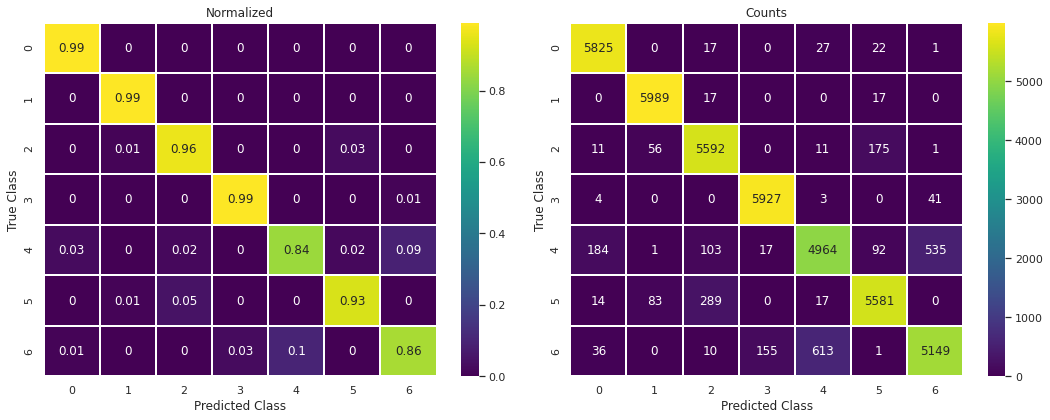

In [373]:
plot_confusion_matrix(random_forest.predict(X_val),
                      random_forest.classes_,
                      y_val)

In [374]:
report_rf = print_model_stats(random_forest, X_val, y_val);

+----+-------------+----------+------------+-----------+
|    |   precision |   recall |   f1-score |   support |
|----+-------------+----------+------------+-----------|
|  0 |    0.959006 | 0.988629 |   0.973592 |      5892 |
|  1 |    0.977158 | 0.994355 |   0.985681 |      6023 |
|  2 |    0.927671 | 0.956551 |   0.94189  |      5846 |
|  3 |    0.971799 | 0.991967 |   0.981779 |      5975 |
|  4 |    0.880923 | 0.841927 |   0.860983 |      5896 |
|  5 |    0.94786  | 0.932654 |   0.940195 |      5984 |
|  6 |    0.899075 | 0.863347 |   0.880849 |      5964 |
+----+-------------+----------+------------+-----------+
f1-score (macro avg) at 95% confidence:	 [0.93549, 0.94013]
Accuracy at 95% confidence:		 [0.93625, 0.94087]


### XGBoost

Si esegue una grid search sul training set con cross validation a 3 fold stratificati casuali per individuare il modello Random Forest con parametri migliori secondo le seguenti specifiche:

  - standardizzazione delle variabili
  - numero di alberi nella foresta (`n_estimators`) variabile in 100, 200, 300
  - profondità massima di un albero `max_depth` variabile in 6, 7 
  - tasso di apprendimento `eta` variabile in $[0.01, 0.25]$
  - parametro per la regolarizzazione l1 `alpha`
  - parametro per la regolarizzazione l2 `lambda`

In [375]:
xgb = Pipeline([
      ("std", StandardScaler()),
      ("xgb", XGBClassifier(booster = 'gbtree',
                            objective = "multi:softmax",
                            num_class = 7,
                            use_label_encoder = False,
                            random_state = seed,
                            nthread = njobs,
                            eval_metric = "mlogloss"
                         ))
])

parameters = {
    "xgb__n_estimators" : [100, 200, 300],
    "xgb__max_depth" : [6, 7],
    "xgb__eta" : [0.1, 0.15, 0.25],
    "xgb__alpha" : [0.001, 0.01, 0,  1, 10],
    "xbg__lambda": [0.001, 0.01, 0,  1, 10]
}

skf = StratifiedKFold(3, shuffle = True)
gs = GridSearchCV(xgb,
                  parameters,
                  cv = skf,
                  refit = True)

In [376]:
%%time
xgb.fit(X_train, y_train)

CPU times: user 3min 56s, sys: 13.5 ms, total: 3min 56s
Wall time: 15.4 s


Pipeline(steps=[('std', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='mlogloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, nthread=-1, num_class=7,
                               num_parallel_tree=1, objective='multi:softprob',
                               random_state=43, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', use_label_encoder

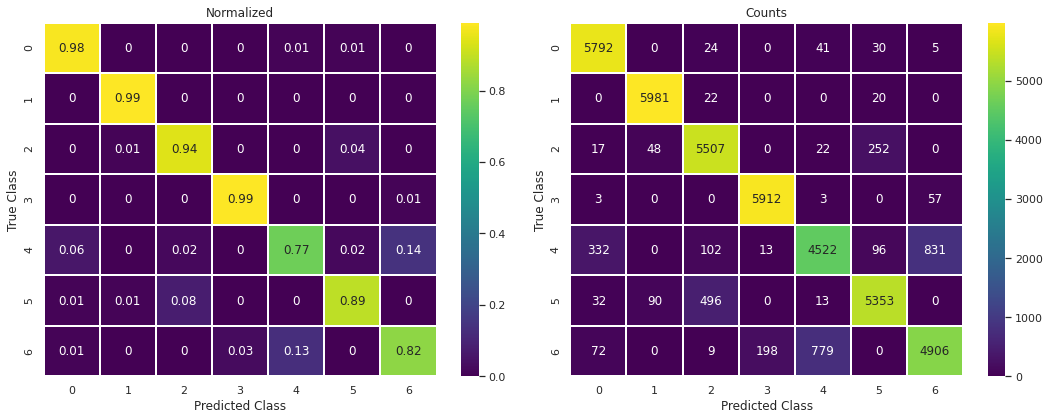

In [377]:
plot_confusion_matrix(xgb.predict(X_val), xgb.classes_, y_val)

In [378]:
report_xgb = print_model_stats(xgb, X_val, y_val);

+----+-------------+----------+------------+-----------+
|    |   precision |   recall |   f1-score |   support |
|----+-------------+----------+------------+-----------|
|  0 |    0.927017 | 0.983028 |   0.954201 |      5892 |
|  1 |    0.977447 | 0.993027 |   0.985175 |      6023 |
|  2 |    0.893994 | 0.942012 |   0.917375 |      5846 |
|  3 |    0.96554  | 0.989456 |   0.977352 |      5975 |
|  4 |    0.84052  | 0.766961 |   0.802057 |      5896 |
|  5 |    0.930795 | 0.894552 |   0.912314 |      5984 |
|  6 |    0.846008 | 0.822602 |   0.834141 |      5964 |
+----+-------------+----------+------------+-----------+
f1-score (macro avg) at 95% confidence:	 [0.90904, 0.91449]
Accuracy at 95% confidence:		 [0.91051, 0.91592]


### Rete neurale

In [379]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import FalseNegatives
from tensorflow.keras.metrics import FalsePositives
from tensorflow.keras.metrics import TrueNegatives
from tensorflow.keras.metrics import TruePositives
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [380]:
# Tensorflow works with NumPy arrays
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

neural_network = Sequential([
    InputLayer(X_train.shape[1]),
    Dense(64, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(7, activation = 'softmax')
])

In [381]:
X_train.shape

(84420, 56)

In [382]:
neural_network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                3648      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 455       
Total params: 8,263
Trainable params: 8,263
Non-trainable params: 0
_________________________________________________________________


Il modello è composto da 8263 parametri:
- Al primo livello: 56 * 64 pesi + 64 bias.
- Al secondo livello: 64 * 64 pesi + 64 bias.
- Al terzo livello: 64 * 7 pesi + 7 bias.

In [383]:
neural_network.compile(optimizer = Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

fit_history = neural_network.fit(X_train,
                                 y_train, 
                                 epochs = 21,
                                 batch_size = 60,
                                 validation_data = (X_val, y_val),
                                 verbose = 2)

Epoch 1/21
1407/1407 - 1s - loss: 7.5187 - accuracy: 0.3930 - val_loss: 3.3716 - val_accuracy: 0.4245
Epoch 2/21
1407/1407 - 1s - loss: 1.9942 - accuracy: 0.5244 - val_loss: 1.8634 - val_accuracy: 0.5233
Epoch 3/21
1407/1407 - 1s - loss: 1.6111 - accuracy: 0.5658 - val_loss: 1.3850 - val_accuracy: 0.6235
Epoch 4/21
1407/1407 - 1s - loss: 1.3442 - accuracy: 0.5965 - val_loss: 1.6248 - val_accuracy: 0.5586
Epoch 5/21
1407/1407 - 1s - loss: 1.2547 - accuracy: 0.6111 - val_loss: 1.1338 - val_accuracy: 0.6411
Epoch 6/21
1407/1407 - 1s - loss: 1.0922 - accuracy: 0.6344 - val_loss: 1.4875 - val_accuracy: 0.6078
Epoch 7/21
1407/1407 - 1s - loss: 1.0185 - accuracy: 0.6424 - val_loss: 1.2834 - val_accuracy: 0.5975
Epoch 8/21
1407/1407 - 1s - loss: 0.9304 - accuracy: 0.6562 - val_loss: 0.8153 - val_accuracy: 0.6802
Epoch 9/21
1407/1407 - 1s - loss: 0.8337 - accuracy: 0.6748 - val_loss: 0.8726 - val_accuracy: 0.6280
Epoch 10/21
1407/1407 - 1s - loss: 0.7951 - accuracy: 0.6820 - val_loss: 0.6845 - 

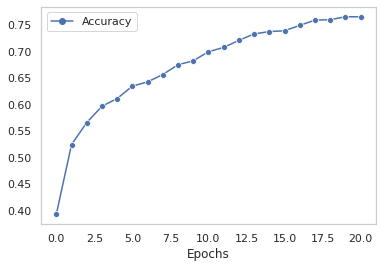

In [384]:
g = sns.lineplot(data = {"Accuracy" : fit_history.history["accuracy"]},
             markers = True,
             dashes = False);
g.set(xlabel = "Epochs");

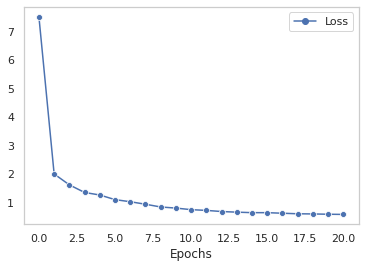

In [385]:
g = sns.lineplot(data = {"Loss" : fit_history.history["loss"]},
             markers = True,
             dashes = False);
g.set(xlabel = "Epochs");

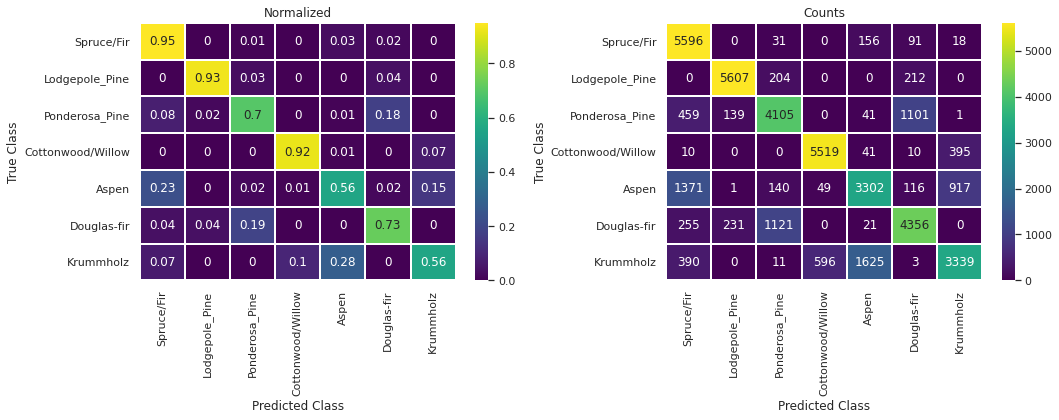

In [386]:
model_classes = list(cover_types.values())
y_pred = np.argmax(neural_network.predict(X_val), axis = -1)

cm = confusion_matrix(y_val, y_pred)
norm_cm = np.around(cm / cm.sum(axis = 1), 2)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))

g = sns.heatmap(norm_cm,
                ax = axes[0],
                annot = True,
                linewidths = 1,
                cmap = 'viridis',
                xticklabels = model_classes,
                yticklabels = model_classes)

g.set(xlabel = 'Predicted Class',
      ylabel = 'True Class',
      title = 'Normalized')

g = sns.heatmap(cm,
                ax = axes[1],
                annot = True,
                fmt = "d",
                linewidths = 1,
                cmap = 'viridis', 
                xticklabels = model_classes,
                yticklabels = model_classes)

g.set(xlabel = 'Predicted Class',
      ylabel = 'True Class',
      title = 'Counts')

plt.tight_layout()
plt.show()

In [387]:
accuracy_snn = neural_network.evaluate(X_val, y_val)[1]
f1_score_snn = f1_score(y_val, y_pred, average = "macro")

1300/1300 [==============================] - 1s 834us/step - loss: 0.5691 - accuracy: 0.7654


In [388]:
lower, upper = confidence_interval(len(X_val),
                                   f1_score_snn,
                                   confidence)

print(f"f1-score (macro avg) at {confidence}% " +
      f"confidence:\t [{lower:.5f}, {upper:.5f}]")

lower, upper = confidence_interval(len(X_val),
                                   accuracy_snn,
                                   confidence)

print(f"Accuracy at {confidence}% " + 
      f"confidence:\t\t [{lower:.5f}, {upper:.5f}]")

f1-score (macro avg) at 95% confidence:	 [0.75571, 0.76392]
Accuracy at 95% confidence:		 [0.76127, 0.76942]


## Confronto dei modelli

Per ciascun modello:

- accuratezza sul validation set (valutazione su validation set)
- accuratezza nel caso generale (valutazione su test set)
- significatività statistica

In [389]:
models = pd.DataFrame({
    "model" : ["Support Vector Machines",
               "Logistic Regression", 
               "Random Forest",
               "XGBoost",
               "Decision Tree",
               "Perceptron",
               "Multi-Layer Perceptron",
               "Simple Neural Network"],
    "accuracy" : [report_svm["accuracy"],
                  report_logreg["accuracy"], 
                  report_rf["accuracy"],
                  report_xgb["accuracy"],
                  report_dtr["accuracy"],
                  report_perc["accuracy"],
                  report_mlp["accuracy"],
                  accuracy_snn],
    "f1-score" : [report_svm["macro avg"]["f1-score"],
                  report_logreg["macro avg"]["f1-score"], 
                  report_rf["macro avg"]["f1-score"],
                  report_xgb["macro avg"]["f1-score"],
                  report_dtr["macro avg"]["f1-score"],
                  report_perc["macro avg"]["f1-score"],
                  report_mlp["macro avg"]["f1-score"],
                  f1_score_snn]
})

models = models.sort_values(by = "accuracy", ascending = False)
models

,model,accuracy,f1-score
2,Random Forest,0.938600,0.937853
3,XGBoost,0.913252,0.911802
4,Decision Tree,0.896128,0.895415
6,Multi-Layer Perceptron,0.869937,0.867619
0,Support Vector Machines,0.798509,0.794904
7,Simple Neural Network,0.765368,0.759843
1,Logistic Regression,0.717340,0.714188
5,Perceptron,0.612939,0.605381


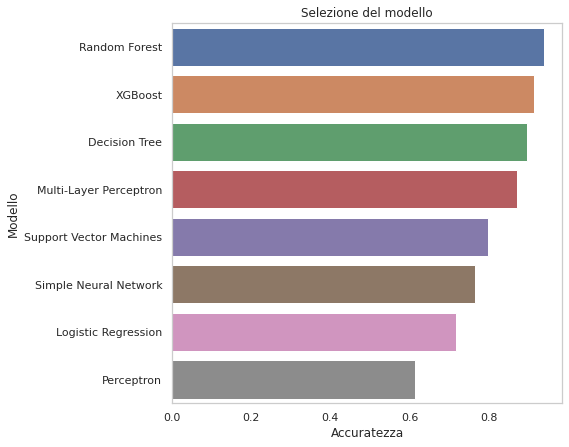

In [390]:
plt.figure(figsize = (7, 7))
g = sns.barplot(y = models["model"], x = models["accuracy"], orient = "h")

g.set(xlabel = "Accuratezza",
      ylabel = "Modello",
      title = "Selezione del modello")
plt.show()

I 3 migliori modelli in termini di accuratezza sono:
- Random Forest
- XGBoost
- Decision Tree

Per determinare quale dei tre modelli è il migliore è necessario verificare se la differenza tra le accuratezze e gli f1 score sono statisticamente significative.

Si verifica se Random Forest è migliore di XGBoost e Decision Tree.

In [391]:
models = models.set_index("model")

In [392]:
compare_two_model(1 - models.loc["Random Forest", "accuracy"],
                  1 - models.loc["XGBoost", "accuracy"],
                  y_val.shape[0],
                  y_val.shape[0])

(0.021792896226082027, 0.02890455447136866)

In [393]:
compare_two_model(1 - models.loc["Random Forest", "f1-score"],
                  1 - models.loc["XGBoost", "f1-score"],
                  y_val.shape[0],
                  y_val.shape[0])

(0.022470883803119512, 0.029630475857545246)

In [394]:
compare_two_model(1 - models.loc["Random Forest", "accuracy"],
                  1 - models.loc["Decision Tree", "accuracy"],
                  y_val.shape[0],
                  y_val.shape[0])

(0.03874080011918717, 0.046203884825497706)

In [395]:
compare_two_model(1 - models.loc["Random Forest", "f1-score"],
                  1 - models.loc["Decision Tree", "f1-score"],
                  y_val.shape[0],
                  y_val.shape[0])

(0.03869094717323035, 0.046184160289422016)

In entrambi i confronti con entrambe le misure è emerso che la differenza tra i modelli Random Forest e XGBoost e tra i modelli Random Forest e Decision Tree rispettivamente sono statisticamente significative. Perciò Random Forest è il miglior modello.

Si effettua un'ultima verifica dell'accuratezza e dell'f1-score dei modelli tramite verifica nel caso generale, impiegando i test set.

In [396]:
round(perceptron_gs.score(X_test, y_test), 3)

0.622

In [397]:
round(logistic_regression.score(X_test, y_test), 3)

0.719

In [398]:
round(svm.score(X_test, y_test), 3)

0.803

In [399]:
round(neural_network.evaluate(X_test, y_test, verbose = 0)[1], 3)

0.774

In [400]:
round(multilayer_perceptron.score(X_test, y_test), 3)

0.873

In [401]:
round(xgb.score(X_test, y_test), 3)

0.915

In [402]:
round(decision_tree_gs.score(X_test, y_test), 3)

0.897

In [403]:
round(random_forest.score(X_test, y_test), 3)

0.942

In [404]:
round(random_forest.score(X_test, y_test), 3)

0.942

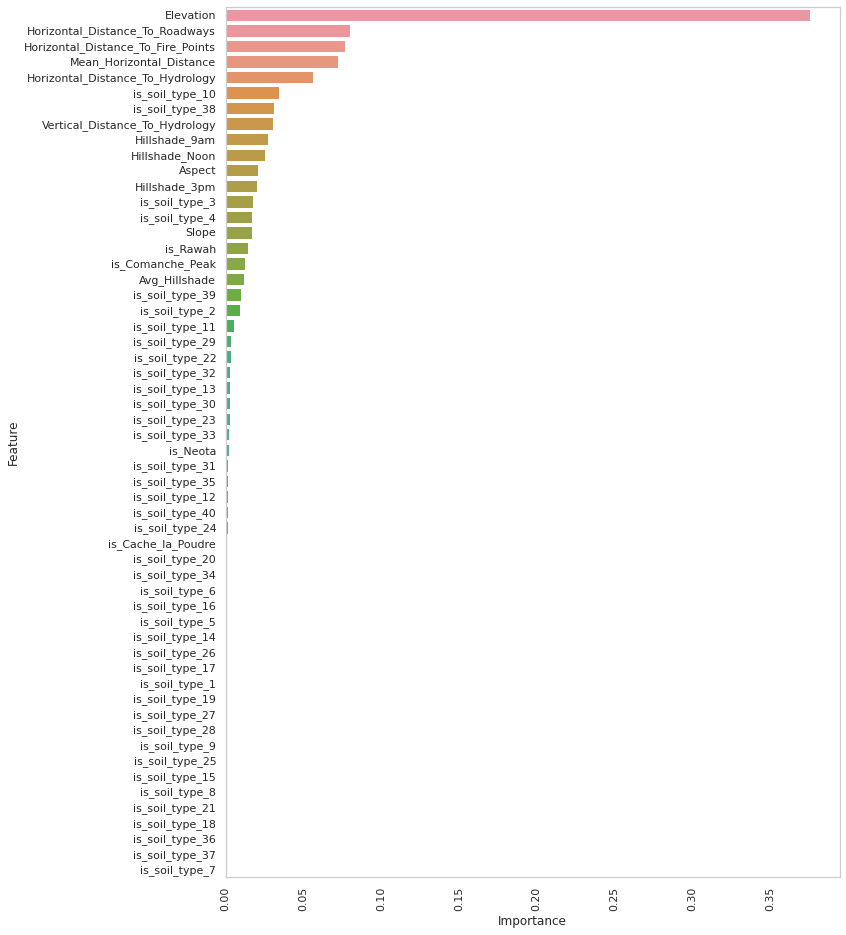

In [405]:
plot_feat_importance(decision_tree_gs.best_estimator_["decisiontree"].feature_importances_,
                     X.columns)

## Interpretabilità dei modelli

Si visualizzano i grafici relativi all'importanza data da ciascun modello tra i tre migliori  alle caratteristiche considerate.

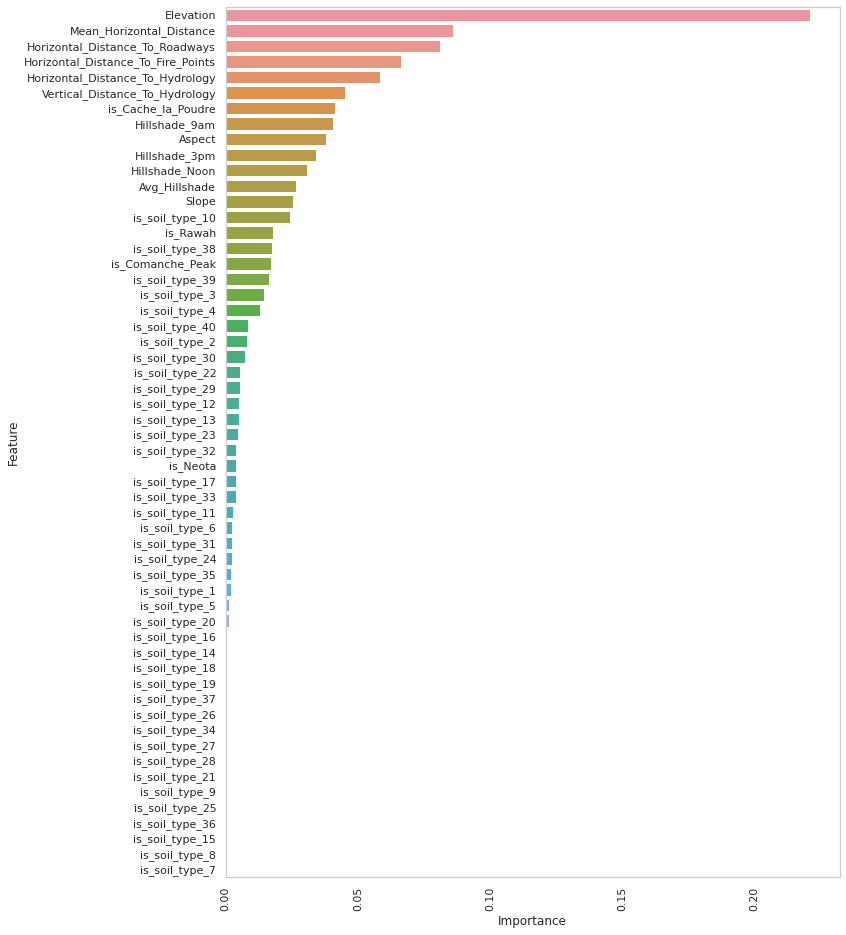

In [406]:
plot_feat_importance(random_forest["rfc"].feature_importances_,
                     X.columns)

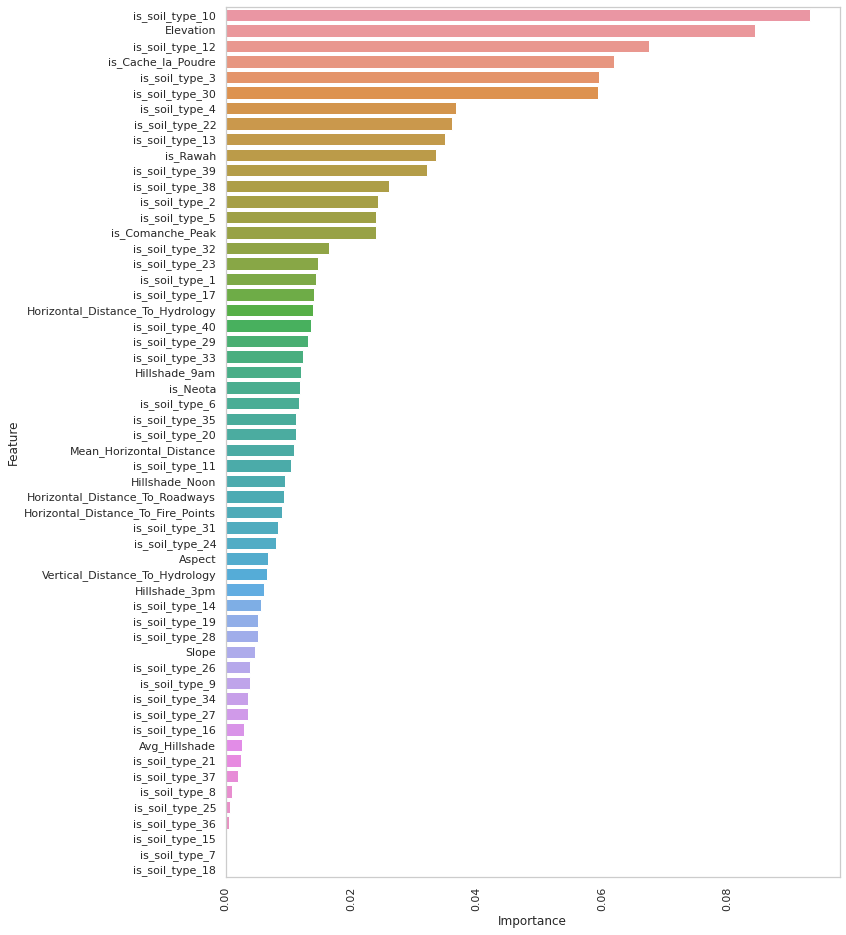

In [407]:
plot_feat_importance(xgb["xgb"].feature_importances_,
                     X.columns)

Si osserva che in Decision Tree è data estrema importanza alla variabile `Elevation` mentre tutti le altre variabili sono molto meno influenti. Al contrario in XGBoost sono considerati molti più parametri. In particolare sia il tipo di campione del terreno che l'area forestale acquisiscono un'influenza che non si ritrova né in Decision Tree né in Random Forest. In quest'ultimo si dà importanza alla distanza dai punti d'interesse, come in Decision Tree, ma anche maggiore rilievo alle aree forestali.

Tra i tre modelli quello che sembra essere maggiormente interpretabile è XGBoost in quanto si osserva che le predizioni che formula danno importanza a molte caratteristiche che si è visto essere potenzialmente influenti e che sono quasi ignorate dagli altri due modelli. 

## Conclusioni

Il dataset è reperibile anche su Kaggle, [qui](https://www.kaggle.com/uciml/forest-cover-type-dataset), ed in passato è stato impiegato in diverse competizioni [[1]](https://www.kaggle.com/c/forest-cover-type-prediction), [[2]](https://www.kaggle.com/c/sd701-cover-type-prediction-of-forests). I risultati ottenuti sono simili a quelli ottenuti dagli altri partecipanti.